<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/AutoGluonForecast_1_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install autogluon

In [2]:
#!pip install --upgrade mxnet

In [3]:
#designed for Jupyter/kaggle/colab
import pandas as pd
import numpy as np
#import matplotlib for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
#import normalization
from sklearn import preprocessing

#autogluon
from autogluon.tabular import TabularDataset, TabularPredictor  

In [4]:
#metatrader5 file format
df=pd.read_csv('/content/EURUSD_M5_201001040000_202202112350.csv')

In [5]:
print(df.head())
print(df.tail())
df.info()

  <DATE>\t<TIME>\t<OPEN>\t<HIGH>\t<LOW>\t<CLOSE>\t<TICKVOL>\t<VOL>\t<SPREAD>
0  2010.01.04\t00:00:00\t1.43259\t1.43259\t1.4321...                        
1  2010.01.04\t00:05:00\t1.43231\t1.43292\t1.4322...                        
2  2010.01.04\t00:10:00\t1.43291\t1.43336\t1.4328...                        
3  2010.01.04\t00:15:00\t1.43291\t1.43321\t1.4324...                        
4  2010.01.04\t00:20:00\t1.43287\t1.43307\t1.4327...                        
       <DATE>\t<TIME>\t<OPEN>\t<HIGH>\t<LOW>\t<CLOSE>\t<TICKVOL>\t<VOL>\t<SPREAD>
899582  2022.02.11\t23:30:00\t1.13489\t1.13495\t1.1345...                        
899583  2022.02.11\t23:35:00\t1.13451\t1.13492\t1.1344...                        
899584  2022.02.11\t23:40:00\t1.13487\t1.13487\t1.1344...                        
899585  2022.02.11\t23:45:00\t1.13464\t1.13465\t1.1344...                        
899586  2022.02.11\t23:50:00\t1.13450\t1.13498\t1.1344...                        
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [6]:
df.columns=['header']


In [7]:
df = df.header.str.split('\t', expand=True)


In [8]:
df

,0,1,2,3,4,5,6,7,8
0,2010.01.04,00:00:00,1.43259,1.43259,1.43213,1.43235,81,0,18
1,2010.01.04,00:05:00,1.43231,1.43292,1.43227,1.43287,64,0,12
2,2010.01.04,00:10:00,1.43291,1.43336,1.43282,1.43293,79,0,16
3,2010.01.04,00:15:00,1.43291,1.43321,1.43240,1.43290,120,0,16
4,2010.01.04,00:20:00,1.43287,1.43307,1.43277,1.43304,79,0,16
...,...,...,...,...,...,...,...,...,...
899582,2022.02.11,23:30:00,1.13489,1.13495,1.13450,1.13451,92,0,7
899583,2022.02.11,23:35:00,1.13451,1.13492,1.13449,1.13485,87,0,11
899584,2022.02.11,23:40:00,1.13487,1.13487,1.13447,1.13464,86,0,15
899585,2022.02.11,23:45:00,1.13464,1.13465,1.13444,1.13450,112,0,14


In [9]:
#choose range of data for backtesting
df['date_time'] = df[0] + ' ' + df[1]
pd.to_datetime(df.date_time)
df.set_index('date_time',inplace=True)
df.drop(columns=[0,1], inplace=True)
df

,2,3,4,5,6,7,8
date_time,,,,,,,
2010.01.04 00:00:00,1.43259,1.43259,1.43213,1.43235,81,0,18
2010.01.04 00:05:00,1.43231,1.43292,1.43227,1.43287,64,0,12
2010.01.04 00:10:00,1.43291,1.43336,1.43282,1.43293,79,0,16
2010.01.04 00:15:00,1.43291,1.43321,1.43240,1.43290,120,0,16
2010.01.04 00:20:00,1.43287,1.43307,1.43277,1.43304,79,0,16
...,...,...,...,...,...,...,...
2022.02.11 23:30:00,1.13489,1.13495,1.13450,1.13451,92,0,7
2022.02.11 23:35:00,1.13451,1.13492,1.13449,1.13485,87,0,11
2022.02.11 23:40:00,1.13487,1.13487,1.13447,1.13464,86,0,15


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 899587 entries, 2010.01.04 00:00:00 to 2022.02.11 23:50:00
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   2       899587 non-null  object
 1   3       899587 non-null  object
 2   4       899587 non-null  object
 3   5       899587 non-null  object
 4   6       899587 non-null  object
 5   7       899587 non-null  object
 6   8       899587 non-null  object
dtypes: object(7)
memory usage: 54.9+ MB


In [11]:
#Choose if you want tail or date_time range here for backtest
#df_close_col = pd.DataFrame(data=df.iloc[:,5].tail(350000))
df_close_col = pd.DataFrame(df.loc['2016.01.03 01:00:00':'2021.12.08 00:00:00',5])

In [12]:
df_close_col.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441901 entries, 2016.01.04 00:00:00 to 2021.12.08 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   5       441901 non-null  object
dtypes: object(1)
memory usage: 6.7+ MB


In [13]:
df_close_col[5] = df_close_col[5].astype(float, errors = 'raise')

In [14]:
df_close_col.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441901 entries, 2016.01.04 00:00:00 to 2021.12.08 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   5       441901 non-null  float64
dtypes: float64(1)
memory usage: 6.7+ MB


In [15]:
df_close_col.isnull().sum()  

5    0
dtype: int64

In [16]:
#return index to int
df_close_col.reset_index(level=['date_time'])

,date_time,5
0,2016.01.04 00:00:00,1.08707
1,2016.01.04 00:05:00,1.08709
2,2016.01.04 00:10:00,1.08660
3,2016.01.04 00:15:00,1.08677
4,2016.01.04 00:20:00,1.08665
...,...,...
441896,2021.12.07 23:40:00,1.12687
441897,2021.12.07 23:45:00,1.12683
441898,2021.12.07 23:50:00,1.12684
441899,2021.12.07 23:55:00,1.12671


In [17]:
###df201 to df240###
df240 = pd.DataFrame(data=df_close_col.iloc[-347040:-345600])
df240['row_num']=np.arange(len(df240))
df240.set_index('row_num',inplace=True)
df240 = df240.rename(columns={5:'day_240'})
print(df240)

df239 = pd.DataFrame(data=df_close_col.iloc[-345600:-344160])
df239['row_num']=np.arange(len(df239))
df239.set_index('row_num',inplace=True)
df239 = df239.rename(columns={5:'day_239'})
print(df239)

df238 = pd.DataFrame(data=df_close_col.iloc[-344160:-342720])
df238['row_num']=np.arange(len(df238))
df238.set_index('row_num',inplace=True)
df238 = df238.rename(columns={5:'day_238'})
print(df238)

df237 = pd.DataFrame(data=df_close_col.iloc[-342720:-341280])
df237['row_num']=np.arange(len(df237))
df237.set_index('row_num',inplace=True)
df237 = df237.rename(columns={5:'day_237'})
print(df237)

df236 = pd.DataFrame(data=df_close_col.iloc[-341280:-339840])
df236['row_num']=np.arange(len(df236))
df236.set_index('row_num',inplace=True)
df236 = df236.rename(columns={5:'day_236'})
print(df236)

df235 = pd.DataFrame(data=df_close_col.iloc[-339840:-338400])
df235['row_num']=np.arange(len(df235))
df235.set_index('row_num',inplace=True)
df235 = df235.rename(columns={5:'day_235'})
print(df235)

df234 = pd.DataFrame(data=df_close_col.iloc[-338400:-336960])
df234['row_num']=np.arange(len(df234))
df234.set_index('row_num',inplace=True)
df234 = df234.rename(columns={5:'day_234'})
print(df234)

df233 = pd.DataFrame(data=df_close_col.iloc[-336960:-335520])
df233['row_num']=np.arange(len(df233))
df233.set_index('row_num',inplace=True)
df233 = df233.rename(columns={5:'day_233'})
print(df233)

df232 = pd.DataFrame(data=df_close_col.iloc[-335520:-334080])
df232['row_num']=np.arange(len(df232))
df232.set_index('row_num',inplace=True)
df232 = df232.rename(columns={5:'day_232'})
print(df232)

df231 = pd.DataFrame(data=df_close_col.iloc[-334080:-332640])
df231['row_num']=np.arange(len(df231))
df231.set_index('row_num',inplace=True)
df231 = df231.rename(columns={5:'day_231'})
print(df231)

df230 = pd.DataFrame(data=df_close_col.iloc[-332640:-331200])
df230['row_num']=np.arange(len(df230))
df230.set_index('row_num',inplace=True)
df230 = df230.rename(columns={5:'day_230'})
print(df230)

df229 = pd.DataFrame(data=df_close_col.iloc[-331200:-329760])
df229['row_num']=np.arange(len(df229))
df229.set_index('row_num',inplace=True)
df229 = df229.rename(columns={5:'day_229'})
print(df229)

df228 = pd.DataFrame(data=df_close_col.iloc[-329760:-328320])
df228['row_num']=np.arange(len(df228))
df228.set_index('row_num',inplace=True)
df228 = df228.rename(columns={5:'day_228'})
print(df228)

df227 = pd.DataFrame(data=df_close_col.iloc[-328320:-326880])
df227['row_num']=np.arange(len(df227))
df227.set_index('row_num',inplace=True)
df227 = df227.rename(columns={5:'day_227'})
print(df227)

df226 = pd.DataFrame(data=df_close_col.iloc[-326880:-325440])
df226['row_num']=np.arange(len(df226))
df226.set_index('row_num',inplace=True)
df226 = df226.rename(columns={5:'day_226'})
print(df226)

df225 = pd.DataFrame(data=df_close_col.iloc[-325440:-324000])
df225['row_num']=np.arange(len(df225))
df225.set_index('row_num',inplace=True)
df225 = df225.rename(columns={5:'day_225'})
print(df225)

df224 = pd.DataFrame(data=df_close_col.iloc[-324000:-322560])
df224['row_num']=np.arange(len(df224))
df224.set_index('row_num',inplace=True)
df224 = df224.rename(columns={5:'day_224'})
print(df224)

df223 = pd.DataFrame(data=df_close_col.iloc[-322560:-321120])
df223['row_num']=np.arange(len(df223))
df223.set_index('row_num',inplace=True)
df223 = df223.rename(columns={5:'day_223'})
print(df223)

df222 = pd.DataFrame(data=df_close_col.iloc[-321120:-319680])
df222['row_num']=np.arange(len(df222))
df222.set_index('row_num',inplace=True)
df222 = df222.rename(columns={5:'day_222'})
print(df222)

df221 = pd.DataFrame(data=df_close_col.iloc[-319680:-318240])
df221['row_num']=np.arange(len(df221))
df221.set_index('row_num',inplace=True)
df221 = df221.rename(columns={5:'day_221'})
print(df221)


df220 = pd.DataFrame(data=df_close_col.iloc[-318240:-316800])
df220['row_num']=np.arange(len(df220))
df220.set_index('row_num',inplace=True)
df220 = df220.rename(columns={5:'day_220'})
print(df220)

df219 = pd.DataFrame(data=df_close_col.iloc[-316800:-315360])
df219['row_num']=np.arange(len(df219))
df219.set_index('row_num',inplace=True)
df219 = df219.rename(columns={5:'day_219'})
print(df219)

df218 = pd.DataFrame(data=df_close_col.iloc[-315360:-313920])
df218['row_num']=np.arange(len(df218))
df218.set_index('row_num',inplace=True)
df218 = df218.rename(columns={5:'day_218'})
print(df218)

df217 = pd.DataFrame(data=df_close_col.iloc[-313920:-312480])
df217['row_num']=np.arange(len(df217))
df217.set_index('row_num',inplace=True)
df217 = df217.rename(columns={5:'day_217'})
print(df217)

df216 = pd.DataFrame(data=df_close_col.iloc[-312480:-311040])
df216['row_num']=np.arange(len(df216))
df216.set_index('row_num',inplace=True)
df216 = df216.rename(columns={5:'day_216'})
print(df216)

df215 = pd.DataFrame(data=df_close_col.iloc[-311040:-309600])
df215['row_num']=np.arange(len(df215))
df215.set_index('row_num',inplace=True)
df215 = df215.rename(columns={5:'day_215'})
print(df215)

df214 = pd.DataFrame(data=df_close_col.iloc[-309600:-308160])
df214['row_num']=np.arange(len(df214))
df214.set_index('row_num',inplace=True)
df214 = df214.rename(columns={5:'day_214'})
print(df214)

df213 = pd.DataFrame(data=df_close_col.iloc[-308160:-306720])
df213['row_num']=np.arange(len(df213))
df213.set_index('row_num',inplace=True)
df213 = df213.rename(columns={5:'day_213'})
print(df213)

df212 = pd.DataFrame(data=df_close_col.iloc[-306720:-305280])
df212['row_num']=np.arange(len(df212))
df212.set_index('row_num',inplace=True)
df212 = df212.rename(columns={5:'day_212'})
print(df212)

df211 = pd.DataFrame(data=df_close_col.iloc[-305280:-303840])
df211['row_num']=np.arange(len(df211))
df211.set_index('row_num',inplace=True)
df211 = df211.rename(columns={5:'day_211'})
print(df211)

df210 = pd.DataFrame(data=df_close_col.iloc[-303840:-302400])
df210['row_num']=np.arange(len(df210))
df210.set_index('row_num',inplace=True)
df210 = df210.rename(columns={5:'day_210'})
print(df210)

df209 = pd.DataFrame(data=df_close_col.iloc[-302400:-300960])
df209['row_num']=np.arange(len(df209))
df209.set_index('row_num',inplace=True)
df209 = df209.rename(columns={5:'day_209'})
print(df209)

df208 = pd.DataFrame(data=df_close_col.iloc[-300960:-299520])
df208['row_num']=np.arange(len(df208))
df208.set_index('row_num',inplace=True)
df208 = df208.rename(columns={5:'day_208'})
print(df208)

df207 = pd.DataFrame(data=df_close_col.iloc[-299520:-298080])
df207['row_num']=np.arange(len(df207))
df207.set_index('row_num',inplace=True)
df207 = df207.rename(columns={5:'day_207'})
print(df207)

df206 = pd.DataFrame(data=df_close_col.iloc[-298080:-296640])
df206['row_num']=np.arange(len(df206))
df206.set_index('row_num',inplace=True)
df206 = df206.rename(columns={5:'day_206'})
print(df206)

df205 = pd.DataFrame(data=df_close_col.iloc[-296640:-295200])
df205['row_num']=np.arange(len(df205))
df205.set_index('row_num',inplace=True)
df205 = df205.rename(columns={5:'day_205'})
print(df205)

df204 = pd.DataFrame(data=df_close_col.iloc[-295200:-293760])
df204['row_num']=np.arange(len(df204))
df204.set_index('row_num',inplace=True)
df204 = df204.rename(columns={5:'day_204'})
print(df204)

df203 = pd.DataFrame(data=df_close_col.iloc[-293760:-292320])
df203['row_num']=np.arange(len(df203))
df203.set_index('row_num',inplace=True)
df203 = df203.rename(columns={5:'day_203'})
print(df203)

df202 = pd.DataFrame(data=df_close_col.iloc[-292320:-290880])
df202['row_num']=np.arange(len(df202))
df202.set_index('row_num',inplace=True)
df202 = df202.rename(columns={5:'day_202'})
print(df202)

df201 = pd.DataFrame(data=df_close_col.iloc[-290880:-289440])
df201['row_num']=np.arange(len(df201))
df201.set_index('row_num',inplace=True)
df201 = df201.rename(columns={5:'day_201'})
print(df201)
###df201 to df 240###

         day_240
row_num         
0        1.05788
1        1.05798
2        1.05809
3        1.05808
4        1.05798
...          ...
1435     1.06136
1436     1.06099
1437     1.06107
1438     1.06135
1439     1.06153

[1440 rows x 1 columns]
         day_239
row_num         
0        1.06176
1        1.06193
2        1.06172
3        1.06163
4        1.06184
...          ...
1435     1.08560
1436     1.08558
1437     1.08515
1438     1.08517
1439     1.08425

[1440 rows x 1 columns]
         day_238
row_num         
0        1.08421
1        1.08455
2        1.08500
3        1.08462
4        1.08479
...          ...
1435     1.09044
1436     1.09034
1437     1.09022
1438     1.09032
1439     1.09034

[1440 rows x 1 columns]
         day_237
row_num         
0        1.09020
1        1.09024
2        1.09011
3        1.09026
4        1.09019
...          ...
1435     1.09667
1436     1.09639
1437     1.09638
1438     1.09695
1439     1.09679

[1440 rows x 1 columns]
         day_236

In [18]:
###df161 to df200###
df200 = pd.DataFrame(data=df_close_col.iloc[-289440:-288000])
df200['row_num']=np.arange(len(df200))
df200.set_index('row_num',inplace=True)
df200 = df200.rename(columns={5:'day_200'})
print(df200)

df199 = pd.DataFrame(data=df_close_col.iloc[-288000:-286560])
df199['row_num']=np.arange(len(df199))
df199.set_index('row_num',inplace=True)
df199 = df199.rename(columns={5:'day_199'})
print(df199)

df198 = pd.DataFrame(data=df_close_col.iloc[-286560:-285120])
df198['row_num']=np.arange(len(df198))
df198.set_index('row_num',inplace=True)
df198 = df198.rename(columns={5:'day_198'})
print(df198)

df197 = pd.DataFrame(data=df_close_col.iloc[-285120:-283680])
df197['row_num']=np.arange(len(df197))
df197.set_index('row_num',inplace=True)
df197 = df197.rename(columns={5:'day_197'})
print(df197)

df196 = pd.DataFrame(data=df_close_col.iloc[-283680:-282240])
df196['row_num']=np.arange(len(df196))
df196.set_index('row_num',inplace=True)
df196 = df196.rename(columns={5:'day_196'})
print(df196)

df195 = pd.DataFrame(data=df_close_col.iloc[-282240:-280800])
df195['row_num']=np.arange(len(df195))
df195.set_index('row_num',inplace=True)
df195 = df195.rename(columns={5:'day_195'})
print(df195)

df194 = pd.DataFrame(data=df_close_col.iloc[-280800:-279360])
df194['row_num']=np.arange(len(df194))
df194.set_index('row_num',inplace=True)
df194 = df194.rename(columns={5:'day_194'})
print(df194)

df193 = pd.DataFrame(data=df_close_col.iloc[-279360:-277920])
df193['row_num']=np.arange(len(df193))
df193.set_index('row_num',inplace=True)
df193 = df193.rename(columns={5:'day_193'})
print(df193)

df192 = pd.DataFrame(data=df_close_col.iloc[-277920:-276480])
df192['row_num']=np.arange(len(df192))
df192.set_index('row_num',inplace=True)
df192 = df192.rename(columns={5:'day_192'})
print(df192)

df191 = pd.DataFrame(data=df_close_col.iloc[-276480:-275040])
df191['row_num']=np.arange(len(df191))
df191.set_index('row_num',inplace=True)
df191 = df191.rename(columns={5:'day_191'})
print(df191)

df190 = pd.DataFrame(data=df_close_col.iloc[-275040:-273600])
df190['row_num']=np.arange(len(df190))
df190.set_index('row_num',inplace=True)
df190 = df190.rename(columns={5:'day_190'})
print(df190)

df189 = pd.DataFrame(data=df_close_col.iloc[-273600:-272160])
df189['row_num']=np.arange(len(df189))
df189.set_index('row_num',inplace=True)
df189 = df189.rename(columns={5:'day_189'})
print(df189)

df188 = pd.DataFrame(data=df_close_col.iloc[-272160:-270720])
df188['row_num']=np.arange(len(df188))
df188.set_index('row_num',inplace=True)
df188 = df188.rename(columns={5:'day_188'})
print(df188)

df187 = pd.DataFrame(data=df_close_col.iloc[-270720:-269280])
df187['row_num']=np.arange(len(df187))
df187.set_index('row_num',inplace=True)
df187 = df187.rename(columns={5:'day_187'})
print(df187)

df186 = pd.DataFrame(data=df_close_col.iloc[-269280:-267840])
df186['row_num']=np.arange(len(df186))
df186.set_index('row_num',inplace=True)
df186 = df186.rename(columns={5:'day_186'})
print(df186)

df185 = pd.DataFrame(data=df_close_col.iloc[-267840:-266400])
df185['row_num']=np.arange(len(df185))
df185.set_index('row_num',inplace=True)
df185 = df185.rename(columns={5:'day_185'})
print(df185)

df184 = pd.DataFrame(data=df_close_col.iloc[-266400:-264960])
df184['row_num']=np.arange(len(df184))
df184.set_index('row_num',inplace=True)
df184 = df184.rename(columns={5:'day_184'})
print(df184)

df183 = pd.DataFrame(data=df_close_col.iloc[-264960:-263520])
df183['row_num']=np.arange(len(df183))
df183.set_index('row_num',inplace=True)
df183 = df183.rename(columns={5:'day_183'})
print(df183)

df182 = pd.DataFrame(data=df_close_col.iloc[-263520:-262080])
df182['row_num']=np.arange(len(df182))
df182.set_index('row_num',inplace=True)
df182 = df182.rename(columns={5:'day_182'})
print(df182)

df181 = pd.DataFrame(data=df_close_col.iloc[-262080:-260640])
df181['row_num']=np.arange(len(df181))
df181.set_index('row_num',inplace=True)
df181 = df181.rename(columns={5:'day_181'})
print(df181)


df180 = pd.DataFrame(data=df_close_col.iloc[-260640:-259200])
df180['row_num']=np.arange(len(df180))
df180.set_index('row_num',inplace=True)
df180 = df180.rename(columns={5:'day_180'})
print(df180)

df179 = pd.DataFrame(data=df_close_col.iloc[-259200:-257760])
df179['row_num']=np.arange(len(df179))
df179.set_index('row_num',inplace=True)
df179 = df179.rename(columns={5:'day_179'})
print(df179)

df178 = pd.DataFrame(data=df_close_col.iloc[-257760:-256320])
df178['row_num']=np.arange(len(df178))
df178.set_index('row_num',inplace=True)
df178 = df178.rename(columns={5:'day_178'})
print(df178)

df177 = pd.DataFrame(data=df_close_col.iloc[-256320:-254880])
df177['row_num']=np.arange(len(df177))
df177.set_index('row_num',inplace=True)
df177 = df177.rename(columns={5:'day_177'})
print(df177)

df176 = pd.DataFrame(data=df_close_col.iloc[-254880:-253440])
df176['row_num']=np.arange(len(df176))
df176.set_index('row_num',inplace=True)
df176 = df176.rename(columns={5:'day_176'})
print(df176)

df175 = pd.DataFrame(data=df_close_col.iloc[-253440:-252000])
df175['row_num']=np.arange(len(df175))
df175.set_index('row_num',inplace=True)
df175 = df175.rename(columns={5:'day_175'})
print(df175)

df174 = pd.DataFrame(data=df_close_col.iloc[-252000:-250560])
df174['row_num']=np.arange(len(df174))
df174.set_index('row_num',inplace=True)
df174 = df174.rename(columns={5:'day_174'})
print(df174)

df173 = pd.DataFrame(data=df_close_col.iloc[-250560:-249120])
df173['row_num']=np.arange(len(df173))
df173.set_index('row_num',inplace=True)
df173 = df173.rename(columns={5:'day_173'})
print(df173)

df172 = pd.DataFrame(data=df_close_col.iloc[-249120:-247680])
df172['row_num']=np.arange(len(df172))
df172.set_index('row_num',inplace=True)
df172 = df172.rename(columns={5:'day_172'})
print(df172)

df171 = pd.DataFrame(data=df_close_col.iloc[-247680:-246240])
df171['row_num']=np.arange(len(df171))
df171.set_index('row_num',inplace=True)
df171 = df171.rename(columns={5:'day_171'})
print(df171)

df170 = pd.DataFrame(data=df_close_col.iloc[-246240:-244800])
df170['row_num']=np.arange(len(df170))
df170.set_index('row_num',inplace=True)
df170 = df170.rename(columns={5:'day_170'})
print(df170)

df169 = pd.DataFrame(data=df_close_col.iloc[-244800:-243360])
df169['row_num']=np.arange(len(df169))
df169.set_index('row_num',inplace=True)
df169 = df169.rename(columns={5:'day_169'})
print(df169)

df168 = pd.DataFrame(data=df_close_col.iloc[-243360:-241920])
df168['row_num']=np.arange(len(df168))
df168.set_index('row_num',inplace=True)
df168 = df168.rename(columns={5:'day_168'})
print(df168)

df167 = pd.DataFrame(data=df_close_col.iloc[-241920:-240480])
df167['row_num']=np.arange(len(df167))
df167.set_index('row_num',inplace=True)
df167 = df167.rename(columns={5:'day_167'})
print(df167)

df166 = pd.DataFrame(data=df_close_col.iloc[-240480:-239040])
df166['row_num']=np.arange(len(df166))
df166.set_index('row_num',inplace=True)
df166 = df166.rename(columns={5:'day_166'})
print(df166)

df165 = pd.DataFrame(data=df_close_col.iloc[-239040:-237600])
df165['row_num']=np.arange(len(df165))
df165.set_index('row_num',inplace=True)
df165 = df165.rename(columns={5:'day_165'})
print(df165)

df164 = pd.DataFrame(data=df_close_col.iloc[-237600:-236160])
df164['row_num']=np.arange(len(df164))
df164.set_index('row_num',inplace=True)
df164 = df164.rename(columns={5:'day_164'})
print(df164)

df163 = pd.DataFrame(data=df_close_col.iloc[-236160:-234720])
df163['row_num']=np.arange(len(df163))
df163.set_index('row_num',inplace=True)
df163 = df163.rename(columns={5:'day_163'})
print(df163)

df162 = pd.DataFrame(data=df_close_col.iloc[-234720:-233280])
df162['row_num']=np.arange(len(df162))
df162.set_index('row_num',inplace=True)
df162 = df162.rename(columns={5:'day_162'})
print(df162)

df161 = pd.DataFrame(data=df_close_col.iloc[-233280:-231840])
df161['row_num']=np.arange(len(df161))
df161.set_index('row_num',inplace=True)
df161 = df161.rename(columns={5:'day_161'})
print(df161)
###df161 to df200###

         day_200
row_num         
0        1.21955
1        1.21920
2        1.21954
3        1.21946
4        1.21941
...          ...
1435     1.24081
1436     1.24120
1437     1.24115
1438     1.24129
1439     1.24115

[1440 rows x 1 columns]
         day_199
row_num         
0        1.24114
1        1.24185
2        1.24161
3        1.24237
4        1.24245
...          ...
1435     1.24219
1436     1.24260
1437     1.24228
1438     1.24238
1439     1.24222

[1440 rows x 1 columns]
         day_198
row_num         
0        1.24206
1        1.24201
2        1.24182
3        1.24182
4        1.24198
...          ...
1435     1.22698
1436     1.22721
1437     1.22725
1438     1.22742
1439     1.22777

[1440 rows x 1 columns]
         day_197
row_num         
0        1.22771
1        1.22759
2        1.22777
3        1.22769
4        1.22760
...          ...
1435     1.24574
1436     1.24589
1437     1.24594
1438     1.24601
1439     1.24574

[1440 rows x 1 columns]
         day_196

In [19]:
###df121 to df160###
df160 = pd.DataFrame(data=df_close_col.iloc[-231840:-230400])
df160['row_num']=np.arange(len(df160))
df160.set_index('row_num',inplace=True)
df160 = df160.rename(columns={5:'day_160'})
print(df160)

df159 = pd.DataFrame(data=df_close_col.iloc[-230400:-228960])
df159['row_num']=np.arange(len(df159))
df159.set_index('row_num',inplace=True)
df159 = df159.rename(columns={5:'day_159'})
print(df159)

df158 = pd.DataFrame(data=df_close_col.iloc[-228960:-227520])
df158['row_num']=np.arange(len(df158))
df158.set_index('row_num',inplace=True)
df158 = df158.rename(columns={5:'day_158'})
print(df158)

df157 = pd.DataFrame(data=df_close_col.iloc[-227520:-226080])
df157['row_num']=np.arange(len(df157))
df157.set_index('row_num',inplace=True)
df157 = df157.rename(columns={5:'day_157'})
print(df157)

df156 = pd.DataFrame(data=df_close_col.iloc[-226080:-224640])
df156['row_num']=np.arange(len(df156))
df156.set_index('row_num',inplace=True)
df156 = df156.rename(columns={5:'day_156'})
print(df156)

df155 = pd.DataFrame(data=df_close_col.iloc[-224640:-223200])
df155['row_num']=np.arange(len(df155))
df155.set_index('row_num',inplace=True)
df155 = df155.rename(columns={5:'day_155'})
print(df155)

df154 = pd.DataFrame(data=df_close_col.iloc[-223200:-221760])
df154['row_num']=np.arange(len(df154))
df154.set_index('row_num',inplace=True)
df154 = df154.rename(columns={5:'day_154'})
print(df154)

df153 = pd.DataFrame(data=df_close_col.iloc[-221760:-220320])
df153['row_num']=np.arange(len(df153))
df153.set_index('row_num',inplace=True)
df153 = df153.rename(columns={5:'day_153'})
print(df153)

df152 = pd.DataFrame(data=df_close_col.iloc[-220320:-218880])
df152['row_num']=np.arange(len(df152))
df152.set_index('row_num',inplace=True)
df152 = df152.rename(columns={5:'day_152'})
print(df152)

df151 = pd.DataFrame(data=df_close_col.iloc[-218880:-217440])
df151['row_num']=np.arange(len(df151))
df151.set_index('row_num',inplace=True)
df151 = df151.rename(columns={5:'day_151'})
print(df151)

df150 = pd.DataFrame(data=df_close_col.iloc[-217440:-216000])
df150['row_num']=np.arange(len(df150))
df150.set_index('row_num',inplace=True)
df150 = df150.rename(columns={5:'day_150'})
print(df150)

df149 = pd.DataFrame(data=df_close_col.iloc[-216000:-214560])
df149['row_num']=np.arange(len(df149))
df149.set_index('row_num',inplace=True)
df149 = df149.rename(columns={5:'day_149'})
print(df149)

df148 = pd.DataFrame(data=df_close_col.iloc[-214560:-213120])
df148['row_num']=np.arange(len(df148))
df148.set_index('row_num',inplace=True)
df148 = df148.rename(columns={5:'day_148'})
print(df148)

df147 = pd.DataFrame(data=df_close_col.iloc[-213120:-211680])
df147['row_num']=np.arange(len(df147))
df147.set_index('row_num',inplace=True)
df147 = df147.rename(columns={5:'day_147'})
print(df147)

df146 = pd.DataFrame(data=df_close_col.iloc[-211680:-210240])
df146['row_num']=np.arange(len(df146))
df146.set_index('row_num',inplace=True)
df146 = df146.rename(columns={5:'day_146'})
print(df146)

df145 = pd.DataFrame(data=df_close_col.iloc[-210240:-208800])
df145['row_num']=np.arange(len(df145))
df145.set_index('row_num',inplace=True)
df145 = df145.rename(columns={5:'day_145'})
print(df145)

df144 = pd.DataFrame(data=df_close_col.iloc[-208800:-207360])
df144['row_num']=np.arange(len(df144))
df144.set_index('row_num',inplace=True)
df144 = df144.rename(columns={5:'day_144'})
print(df144)

df143 = pd.DataFrame(data=df_close_col.iloc[-207360:-205920])
df143['row_num']=np.arange(len(df143))
df143.set_index('row_num',inplace=True)
df143 = df143.rename(columns={5:'day_143'})
print(df143)

df142 = pd.DataFrame(data=df_close_col.iloc[-205920:-204480])
df142['row_num']=np.arange(len(df142))
df142.set_index('row_num',inplace=True)
df142 = df142.rename(columns={5:'day_142'})
print(df142)

df141 = pd.DataFrame(data=df_close_col.iloc[-204480:-203040])
df141['row_num']=np.arange(len(df141))
df141.set_index('row_num',inplace=True)
df141 = df141.rename(columns={5:'day_141'})
print(df141)


df140 = pd.DataFrame(data=df_close_col.iloc[-203040:-201600])
df140['row_num']=np.arange(len(df140))
df140.set_index('row_num',inplace=True)
df140 = df140.rename(columns={5:'day_140'})
print(df140)

df139 = pd.DataFrame(data=df_close_col.iloc[-201600:-200160])
df139['row_num']=np.arange(len(df139))
df139.set_index('row_num',inplace=True)
df139 = df139.rename(columns={5:'day_139'})
print(df139)

df138 = pd.DataFrame(data=df_close_col.iloc[-200160:-198720])
df138['row_num']=np.arange(len(df138))
df138.set_index('row_num',inplace=True)
df138 = df138.rename(columns={5:'day_138'})
print(df138)

df137 = pd.DataFrame(data=df_close_col.iloc[-198720:-197280])
df137['row_num']=np.arange(len(df137))
df137.set_index('row_num',inplace=True)
df137 = df137.rename(columns={5:'day_137'})
print(df137)

df136 = pd.DataFrame(data=df_close_col.iloc[-197280:-195840])
df136['row_num']=np.arange(len(df136))
df136.set_index('row_num',inplace=True)
df136 = df136.rename(columns={5:'day_136'})
print(df136)

df135 = pd.DataFrame(data=df_close_col.iloc[-195840:-194400])
df135['row_num']=np.arange(len(df135))
df135.set_index('row_num',inplace=True)
df135 = df135.rename(columns={5:'day_135'})
print(df135)

df134 = pd.DataFrame(data=df_close_col.iloc[-194400:-192960])
df134['row_num']=np.arange(len(df134))
df134.set_index('row_num',inplace=True)
df134 = df134.rename(columns={5:'day_134'})
print(df134)

df133 = pd.DataFrame(data=df_close_col.iloc[-192960:-191520])
df133['row_num']=np.arange(len(df133))
df133.set_index('row_num',inplace=True)
df133 = df133.rename(columns={5:'day_133'})
print(df133)

df132 = pd.DataFrame(data=df_close_col.iloc[-191520:-190080])
df132['row_num']=np.arange(len(df132))
df132.set_index('row_num',inplace=True)
df132 = df132.rename(columns={5:'day_132'})
print(df132)

df131 = pd.DataFrame(data=df_close_col.iloc[-190080:-188640])
df131['row_num']=np.arange(len(df131))
df131.set_index('row_num',inplace=True)
df131 = df131.rename(columns={5:'day_131'})
print(df131)

df130 = pd.DataFrame(data=df_close_col.iloc[-188640:-187200])
df130['row_num']=np.arange(len(df130))
df130.set_index('row_num',inplace=True)
df130 = df130.rename(columns={5:'day_130'})
print(df130)

df129 = pd.DataFrame(data=df_close_col.iloc[-187200:-185760])
df129['row_num']=np.arange(len(df129))
df129.set_index('row_num',inplace=True)
df129 = df129.rename(columns={5:'day_129'})
print(df129)

df128 = pd.DataFrame(data=df_close_col.iloc[-185760:-184320])
df128['row_num']=np.arange(len(df128))
df128.set_index('row_num',inplace=True)
df128 = df128.rename(columns={5:'day_128'})
print(df128)

df127 = pd.DataFrame(data=df_close_col.iloc[-184320:-182880])
df127['row_num']=np.arange(len(df127))
df127.set_index('row_num',inplace=True)
df127 = df127.rename(columns={5:'day_127'})
print(df127)

df126 = pd.DataFrame(data=df_close_col.iloc[-182880:-181440])
df126['row_num']=np.arange(len(df126))
df126.set_index('row_num',inplace=True)
df126 = df126.rename(columns={5:'day_126'})
print(df126)

df125 = pd.DataFrame(data=df_close_col.iloc[-181440:-180000])
df125['row_num']=np.arange(len(df125))
df125.set_index('row_num',inplace=True)
df125 = df125.rename(columns={5:'day_125'})
print(df125)

df124 = pd.DataFrame(data=df_close_col.iloc[-180000:-178560])
df124['row_num']=np.arange(len(df124))
df124.set_index('row_num',inplace=True)
df124 = df124.rename(columns={5:'day_124'})
print(df124)

df123 = pd.DataFrame(data=df_close_col.iloc[-178560:-177120])
df123['row_num']=np.arange(len(df123))
df123.set_index('row_num',inplace=True)
df123 = df123.rename(columns={5:'day_123'})
print(df123)

###
#left out a day here, still need to fix it -177120:-175680
###

df122 = pd.DataFrame(data=df_close_col.iloc[-175680:-174240])
df122['row_num']=np.arange(len(df122))
df122.set_index('row_num',inplace=True)
df122 = df122.rename(columns={5:'day_122'})
print(df122)

df121 = pd.DataFrame(data=df_close_col.iloc[-174240:-172800])
df121['row_num']=np.arange(len(df121))
df121.set_index('row_num',inplace=True)
df121 = df121.rename(columns={5:'day_121'})
print(df121)
###df121 to df160###

         day_160
row_num         
0        1.14109
1        1.14079
2        1.14074
3        1.14074
4        1.14079
...          ...
1435     1.13455
1436     1.13449
1437     1.13453
1438     1.13453
1439     1.13446

[1440 rows x 1 columns]
         day_159
row_num         
0        1.13429
1        1.13414
2        1.13409
3        1.13398
4        1.13404
...          ...
1435     1.14296
1436     1.14299
1437     1.14320
1438     1.14305
1439     1.14312

[1440 rows x 1 columns]
         day_158
row_num         
0        1.14335
1        1.14319
2        1.14313
3        1.14317
4        1.14325
...          ...
1435     1.13341
1436     1.13354
1437     1.13341
1438     1.13345
1439     1.13326

[1440 rows x 1 columns]
         day_157
row_num         
0        1.13324
1        1.13355
2        1.13349
3        1.13395
4        1.13369
...          ...
1435     1.13976
1436     1.13975
1437     1.13970
1438     1.13960
1439     1.13960

[1440 rows x 1 columns]
         day_156

In [20]:
###df80 to df120###
df120 = pd.DataFrame(data=df_close_col.iloc[-172800:-171360])
df120['row_num']=np.arange(len(df120))
df120.set_index('row_num',inplace=True)
df120 = df120.rename(columns={5:'day_120'})
print(df120)

df119 = pd.DataFrame(data=df_close_col.iloc[-171360:-169920])
df119['row_num']=np.arange(len(df119))
df119.set_index('row_num',inplace=True)
df119 = df119.rename(columns={5:'day_119'})
print(df119)

df118 = pd.DataFrame(data=df_close_col.iloc[-169920:-168480])
df118['row_num']=np.arange(len(df118))
df118.set_index('row_num',inplace=True)
df118 = df118.rename(columns={5:'day_118'})
print(df118)

df117 = pd.DataFrame(data=df_close_col.iloc[-168480:-167040])
df117['row_num']=np.arange(len(df117))
df117.set_index('row_num',inplace=True)
df117 = df117.rename(columns={5:'day_117'})
print(df117)

df116 = pd.DataFrame(data=df_close_col.iloc[-167040:-165600])
df116['row_num']=np.arange(len(df116))
df116.set_index('row_num',inplace=True)
df116 = df116.rename(columns={5:'day_116'})
print(df116)

df115 = pd.DataFrame(data=df_close_col.iloc[-165600:-164160])
df115['row_num']=np.arange(len(df115))
df115.set_index('row_num',inplace=True)
df115 = df115.rename(columns={5:'day_115'})
print(df115)

df114 = pd.DataFrame(data=df_close_col.iloc[-164160:-162720])
df114['row_num']=np.arange(len(df114))
df114.set_index('row_num',inplace=True)
df114 = df114.rename(columns={5:'day_114'})
print(df114)

df113 = pd.DataFrame(data=df_close_col.iloc[-162720:-161280])
df113['row_num']=np.arange(len(df113))
df113.set_index('row_num',inplace=True)
df113 = df113.rename(columns={5:'day_113'})
print(df113)

df112 = pd.DataFrame(data=df_close_col.iloc[-161280:-159840])
df112['row_num']=np.arange(len(df112))
df112.set_index('row_num',inplace=True)
df112 = df112.rename(columns={5:'day_112'})
print(df112)

df111 = pd.DataFrame(data=df_close_col.iloc[-159840:-158400])
df111['row_num']=np.arange(len(df111))
df111.set_index('row_num',inplace=True)
df111 = df111.rename(columns={5:'day_111'})
print(df111)

df110 = pd.DataFrame(data=df_close_col.iloc[-158400:-156960])
df110['row_num']=np.arange(len(df110))
df110.set_index('row_num',inplace=True)
df110 = df110.rename(columns={5:'day_110'})
print(df110)

df109 = pd.DataFrame(data=df_close_col.iloc[-156960:-155520])
df109['row_num']=np.arange(len(df109))
df109.set_index('row_num',inplace=True)
df109 = df109.rename(columns={5:'day_109'})
print(df109)

df108 = pd.DataFrame(data=df_close_col.iloc[-155520:-154080])
df108['row_num']=np.arange(len(df108))
df108.set_index('row_num',inplace=True)
df108 = df108.rename(columns={5:'day_108'})
print(df108)

df107 = pd.DataFrame(data=df_close_col.iloc[-154080:-152640])
df107['row_num']=np.arange(len(df107))
df107.set_index('row_num',inplace=True)
df107 = df107.rename(columns={5:'day_107'})
print(df107)

df106 = pd.DataFrame(data=df_close_col.iloc[-152640:-151200])
df106['row_num']=np.arange(len(df106))
df106.set_index('row_num',inplace=True)
df106 = df106.rename(columns={5:'day_106'})
print(df106)

df105 = pd.DataFrame(data=df_close_col.iloc[-151200:-149760])
df105['row_num']=np.arange(len(df105))
df105.set_index('row_num',inplace=True)
df105 = df105.rename(columns={5:'day_105'})
print(df105)

df104 = pd.DataFrame(data=df_close_col.iloc[-149760:-148320])
df104['row_num']=np.arange(len(df104))
df104.set_index('row_num',inplace=True)
df104 = df104.rename(columns={5:'day_104'})
print(df104)

df103 = pd.DataFrame(data=df_close_col.iloc[-148320:-146880])
df103['row_num']=np.arange(len(df103))
df103.set_index('row_num',inplace=True)
df103 = df103.rename(columns={5:'day_103'})
print(df103)

df102 = pd.DataFrame(data=df_close_col.iloc[-146880:-145440])
df102['row_num']=np.arange(len(df102))
df102.set_index('row_num',inplace=True)
df102 = df102.rename(columns={5:'day_102'})
print(df102)

df101 = pd.DataFrame(data=df_close_col.iloc[-145440:-144000])
df101['row_num']=np.arange(len(df101))
df101.set_index('row_num',inplace=True)
df101 = df101.rename(columns={5:'day_101'})
print(df101)


df100 = pd.DataFrame(data=df_close_col.iloc[-144000:-142560])
df100['row_num']=np.arange(len(df100))
df100.set_index('row_num',inplace=True)
df100 = df100.rename(columns={5:'day_100'})
print(df100)

df99 = pd.DataFrame(data=df_close_col.iloc[-142560:-141120])
df99['row_num']=np.arange(len(df99))
df99.set_index('row_num',inplace=True)
df99 = df99.rename(columns={5:'day_99'})
print(df99)

df98 = pd.DataFrame(data=df_close_col.iloc[-141120:-139680])
df98['row_num']=np.arange(len(df98))
df98.set_index('row_num',inplace=True)
df98 = df98.rename(columns={5:'day_98'})
print(df98)

df97 = pd.DataFrame(data=df_close_col.iloc[-139680:-138240])
df97['row_num']=np.arange(len(df97))
df97.set_index('row_num',inplace=True)
df97 = df97.rename(columns={5:'day_97'})
print(df97)

df96 = pd.DataFrame(data=df_close_col.iloc[-138240:-136800])
df96['row_num']=np.arange(len(df96))
df96.set_index('row_num',inplace=True)
df96 = df96.rename(columns={5:'day_96'})
print(df96)

df95 = pd.DataFrame(data=df_close_col.iloc[-136800:-135360])
df95['row_num']=np.arange(len(df95))
df95.set_index('row_num',inplace=True)
df95 = df95.rename(columns={5:'day_95'})
print(df95)

df94 = pd.DataFrame(data=df_close_col.iloc[-135360:-133920])
df94['row_num']=np.arange(len(df94))
df94.set_index('row_num',inplace=True)
df94 = df94.rename(columns={5:'day_94'})
print(df94)

df93 = pd.DataFrame(data=df_close_col.iloc[-133920:-132480])
df93['row_num']=np.arange(len(df93))
df93.set_index('row_num',inplace=True)
df93 = df93.rename(columns={5:'day_93'})
print(df93)

df92 = pd.DataFrame(data=df_close_col.iloc[-132480:-131040])
df92['row_num']=np.arange(len(df92))
df92.set_index('row_num',inplace=True)
df92 = df92.rename(columns={5:'day_92'})
print(df92)

df91 = pd.DataFrame(data=df_close_col.iloc[-131040:-129600])
df91['row_num']=np.arange(len(df91))
df91.set_index('row_num',inplace=True)
df91 = df91.rename(columns={5:'day_91'})
print(df91)

df90 = pd.DataFrame(data=df_close_col.iloc[-129600:-128160])
df90['row_num']=np.arange(len(df90))
df90.set_index('row_num',inplace=True)
df90 = df90.rename(columns={5:'day_90'})
print(df90)

df89 = pd.DataFrame(data=df_close_col.iloc[-128160:-126720])
df89['row_num']=np.arange(len(df89))
df89.set_index('row_num',inplace=True)
df89 = df89.rename(columns={5:'day_89'})
print(df89)

df88 = pd.DataFrame(data=df_close_col.iloc[-126720:-125280])
df88['row_num']=np.arange(len(df88))
df88.set_index('row_num',inplace=True)
df88 = df88.rename(columns={5:'day_88'})
print(df88)

df87 = pd.DataFrame(data=df_close_col.iloc[-125280:-123840])
df87['row_num']=np.arange(len(df87))
df87.set_index('row_num',inplace=True)
df87 = df87.rename(columns={5:'day_87'})
print(df87)

df86 = pd.DataFrame(data=df_close_col.iloc[-123840:-122400])
df86['row_num']=np.arange(len(df86))
df86.set_index('row_num',inplace=True)
df86 = df86.rename(columns={5:'day_86'})
print(df86)

df85 = pd.DataFrame(data=df_close_col.iloc[-122400:-120960])
df85['row_num']=np.arange(len(df85))
df85.set_index('row_num',inplace=True)
df85 = df85.rename(columns={5:'day_85'})
print(df85)

df84 = pd.DataFrame(data=df_close_col.iloc[-120960:-119520])
df84['row_num']=np.arange(len(df84))
df84.set_index('row_num',inplace=True)
df84 = df84.rename(columns={5:'day_84'})
print(df84)

df83 = pd.DataFrame(data=df_close_col.iloc[-119520:-118080])
df83['row_num']=np.arange(len(df83))
df83.set_index('row_num',inplace=True)
df83 = df83.rename(columns={5:'day_83'})
print(df83)

df82 = pd.DataFrame(data=df_close_col.iloc[-118080:-116640])
df82['row_num']=np.arange(len(df82))
df82.set_index('row_num',inplace=True)
df82 = df82.rename(columns={5:'day_82'})
print(df82)

df81 = pd.DataFrame(data=df_close_col.iloc[-116640:-115200])
df81['row_num']=np.arange(len(df81))
df81.set_index('row_num',inplace=True)
df81 = df81.rename(columns={5:'day_81'})
print(df81)
###df80 to df 120###

         day_120
row_num         
0        1.12104
1        1.12113
2        1.12105
3        1.12080
4        1.12092
...          ...
1435     1.10845
1436     1.10855
1437     1.10867
1438     1.10834
1439     1.10839

[1440 rows x 1 columns]
         day_119
row_num         
0        1.10841
1        1.10852
2        1.10848
3        1.10847
4        1.10842
...          ...
1435     1.11015
1436     1.11031
1437     1.11047
1438     1.11029
1439     1.11024

[1440 rows x 1 columns]
         day_118
row_num         
0        1.11028
1        1.11029
2        1.11036
3        1.11031
4        1.11025
...          ...
1435     1.09573
1436     1.09564
1437     1.09582
1438     1.09579
1439     1.09569

[1440 rows x 1 columns]
         day_117
row_num         
0        1.09537
1        1.09525
2        1.09530
3        1.09565
4        1.09549
...          ...
1435     1.10462
1436     1.10462
1437     1.10441
1438     1.10433
1439     1.10438

[1440 rows x 1 columns]
         day_116

In [21]:
###df40 to df80###
df80 = pd.DataFrame(data=df_close_col.iloc[-115200:-113760])
df80['row_num']=np.arange(len(df80))
df80.set_index('row_num',inplace=True)
df80 = df80.rename(columns={5:'day_80'})
print(df80)

df79 = pd.DataFrame(data=df_close_col.iloc[-113760:-112320])
df79['row_num']=np.arange(len(df79))
df79.set_index('row_num',inplace=True)
df79 = df79.rename(columns={5:'day_79'})
print(df79)

df78 = pd.DataFrame(data=df_close_col.iloc[-112320:-110880])
df78['row_num']=np.arange(len(df78))
df78.set_index('row_num',inplace=True)
df78 = df78.rename(columns={5:'day_78'})
print(df78)

df77 = pd.DataFrame(data=df_close_col.iloc[-110880:-109440])
df77['row_num']=np.arange(len(df77))
df77.set_index('row_num',inplace=True)
df77 = df77.rename(columns={5:'day_77'})
print(df77)

df76 = pd.DataFrame(data=df_close_col.iloc[-109440:-108000])
df76['row_num']=np.arange(len(df76))
df76.set_index('row_num',inplace=True)
df76 = df76.rename(columns={5:'day_76'})
print(df76)

df75 = pd.DataFrame(data=df_close_col.iloc[-108000:-106560])
df75['row_num']=np.arange(len(df75))
df75.set_index('row_num',inplace=True)
df75 = df75.rename(columns={5:'day_75'})
print(df75)

df74 = pd.DataFrame(data=df_close_col.iloc[-106560:-105120])
df74['row_num']=np.arange(len(df74))
df74.set_index('row_num',inplace=True)
df74 = df74.rename(columns={5:'day_74'})
print(df74)

df73 = pd.DataFrame(data=df_close_col.iloc[-105120:-103680])
df73['row_num']=np.arange(len(df73))
df73.set_index('row_num',inplace=True)
df73 = df73.rename(columns={5:'day_73'})
print(df73)

df72 = pd.DataFrame(data=df_close_col.iloc[-103680:-102240])
df72['row_num']=np.arange(len(df72))
df72.set_index('row_num',inplace=True)
df72 = df72.rename(columns={5:'day_72'})
print(df72)

df71 = pd.DataFrame(data=df_close_col.iloc[-102240:-100800])
df71['row_num']=np.arange(len(df71))
df71.set_index('row_num',inplace=True)
df71 = df71.rename(columns={5:'day_71'})
print(df71)

df70 = pd.DataFrame(data=df_close_col.iloc[-100800:-99360])
df70['row_num']=np.arange(len(df70))
df70.set_index('row_num',inplace=True)
df70 = df70.rename(columns={5:'day_70'})
print(df70)

df69 = pd.DataFrame(data=df_close_col.iloc[-99360:-97920])
df69['row_num']=np.arange(len(df69))
df69.set_index('row_num',inplace=True)
df69 = df69.rename(columns={5:'day_69'})
print(df69)

df68 = pd.DataFrame(data=df_close_col.iloc[-97920:-96480])
df68['row_num']=np.arange(len(df68))
df68.set_index('row_num',inplace=True)
df68 = df68.rename(columns={5:'day_68'})
print(df68)

df67 = pd.DataFrame(data=df_close_col.iloc[-96480:-95040])
df67['row_num']=np.arange(len(df67))
df67.set_index('row_num',inplace=True)
df67 = df67.rename(columns={5:'day_67'})
print(df67)

df66 = pd.DataFrame(data=df_close_col.iloc[-95040:-93600])
df66['row_num']=np.arange(len(df66))
df66.set_index('row_num',inplace=True)
df66 = df66.rename(columns={5:'day_66'})
print(df66)

df65 = pd.DataFrame(data=df_close_col.iloc[-93600:-92160])
df65['row_num']=np.arange(len(df65))
df65.set_index('row_num',inplace=True)
df65 = df65.rename(columns={5:'day_65'})
print(df65)

df64 = pd.DataFrame(data=df_close_col.iloc[-92160:-90720])
df64['row_num']=np.arange(len(df64))
df64.set_index('row_num',inplace=True)
df64 = df64.rename(columns={5:'day_64'})
print(df64)

df63 = pd.DataFrame(data=df_close_col.iloc[-90720:-89280])
df63['row_num']=np.arange(len(df63))
df63.set_index('row_num',inplace=True)
df63 = df63.rename(columns={5:'day_63'})
print(df63)

df62 = pd.DataFrame(data=df_close_col.iloc[-89280:-87840])
df62['row_num']=np.arange(len(df62))
df62.set_index('row_num',inplace=True)
df62 = df62.rename(columns={5:'day_62'})
print(df62)

df61 = pd.DataFrame(data=df_close_col.iloc[-87840:-86400])
df61['row_num']=np.arange(len(df61))
df61.set_index('row_num',inplace=True)
df61 = df61.rename(columns={5:'day_61'})
print(df61)


df60 = pd.DataFrame(data=df_close_col.iloc[-86400:-84960])
df60['row_num']=np.arange(len(df60))
df60.set_index('row_num',inplace=True)
df60 = df60.rename(columns={5:'day_60'})
print(df60)

df59 = pd.DataFrame(data=df_close_col.iloc[-84960:-83520])
df59['row_num']=np.arange(len(df59))
df59.set_index('row_num',inplace=True)
df59 = df59.rename(columns={5:'day_59'})
print(df59)

df58 = pd.DataFrame(data=df_close_col.iloc[-83520:-82080])
df58['row_num']=np.arange(len(df58))
df58.set_index('row_num',inplace=True)
df58 = df58.rename(columns={5:'day_58'})
print(df58)

df57 = pd.DataFrame(data=df_close_col.iloc[-82080:-80640])
df57['row_num']=np.arange(len(df57))
df57.set_index('row_num',inplace=True)
df57 = df57.rename(columns={5:'day_57'})
print(df57)

df56 = pd.DataFrame(data=df_close_col.iloc[-80640:-79200])
df56['row_num']=np.arange(len(df56))
df56.set_index('row_num',inplace=True)
df56 = df56.rename(columns={5:'day_56'})
print(df56)

df55 = pd.DataFrame(data=df_close_col.iloc[-79200:-77760])
df55['row_num']=np.arange(len(df55))
df55.set_index('row_num',inplace=True)
df55 = df55.rename(columns={5:'day_55'})
print(df55)

df54 = pd.DataFrame(data=df_close_col.iloc[-77760:-76320])
df54['row_num']=np.arange(len(df54))
df54.set_index('row_num',inplace=True)
df54 = df54.rename(columns={5:'day_54'})
print(df54)

df53 = pd.DataFrame(data=df_close_col.iloc[-76320:-74880])
df53['row_num']=np.arange(len(df53))
df53.set_index('row_num',inplace=True)
df53 = df53.rename(columns={5:'day_53'})
print(df53)

df52 = pd.DataFrame(data=df_close_col.iloc[-74880:-73440])
df52['row_num']=np.arange(len(df52))
df52.set_index('row_num',inplace=True)
df52 = df52.rename(columns={5:'day_52'})
print(df52)

df51 = pd.DataFrame(data=df_close_col.iloc[-73440:-72000])
df51['row_num']=np.arange(len(df51))
df51.set_index('row_num',inplace=True)
df51 = df51.rename(columns={5:'day_51'})
print(df51)

df50 = pd.DataFrame(data=df_close_col.iloc[-72000:-70560])
df50['row_num']=np.arange(len(df50))
df50.set_index('row_num',inplace=True)
df50 = df50.rename(columns={5:'day_50'})
print(df50)

df49 = pd.DataFrame(data=df_close_col.iloc[-70560:-69120])
df49['row_num']=np.arange(len(df49))
df49.set_index('row_num',inplace=True)
df49 = df49.rename(columns={5:'day_49'})
print(df49)

df48 = pd.DataFrame(data=df_close_col.iloc[-69120:-67680])
df48['row_num']=np.arange(len(df48))
df48.set_index('row_num',inplace=True)
df48 = df48.rename(columns={5:'day_48'})
print(df48)

df47 = pd.DataFrame(data=df_close_col.iloc[-67680:-66240])
df47['row_num']=np.arange(len(df47))
df47.set_index('row_num',inplace=True)
df47 = df47.rename(columns={5:'day_47'})
print(df47)

df46 = pd.DataFrame(data=df_close_col.iloc[-66240:-64800])
df46['row_num']=np.arange(len(df46))
df46.set_index('row_num',inplace=True)
df46 = df46.rename(columns={5:'day_46'})
print(df46)

df45 = pd.DataFrame(data=df_close_col.iloc[-64800:-63360])
df45['row_num']=np.arange(len(df45))
df45.set_index('row_num',inplace=True)
df45 = df45.rename(columns={5:'day_45'})
print(df45)

df44 = pd.DataFrame(data=df_close_col.iloc[-63360:-61920])
df44['row_num']=np.arange(len(df44))
df44.set_index('row_num',inplace=True)
df44 = df44.rename(columns={5:'day_44'})
print(df44)

df43 = pd.DataFrame(data=df_close_col.iloc[-61920:-60480])
df43['row_num']=np.arange(len(df43))
df43.set_index('row_num',inplace=True)
df43 = df43.rename(columns={5:'day_43'})
print(df43)

df42 = pd.DataFrame(data=df_close_col.iloc[-60480:-59040])
df42['row_num']=np.arange(len(df42))
df42.set_index('row_num',inplace=True)
df42 = df42.rename(columns={5:'day_42'})
print(df42)

df41 = pd.DataFrame(data=df_close_col.iloc[-59040:-57600])
df41['row_num']=np.arange(len(df41))
df41.set_index('row_num',inplace=True)
df41 = df41.rename(columns={5:'day_41'})
print(df41)
###df40 to df80###

          day_80
row_num         
0        1.09519
1        1.09517
2        1.09501
3        1.09505
4        1.09506
...          ...
1435     1.10788
1436     1.10778
1437     1.10772
1438     1.10777
1439     1.10769

[1440 rows x 1 columns]
          day_79
row_num         
0        1.10763
1        1.10738
2        1.10737
3        1.10730
4        1.10741
...          ...
1435     1.13427
1436     1.13407
1437     1.13398
1438     1.13405
1439     1.13377

[1440 rows x 1 columns]
          day_78
row_num         
0        1.13373
1        1.13383
2        1.13386
3        1.13407
4        1.13429
...          ...
1435     1.12901
1436     1.12909
1437     1.12925
1438     1.12965
1439     1.12955

[1440 rows x 1 columns]
          day_77
row_num         
0        1.12985
1        1.12959
2        1.12946
3        1.12931
4        1.12920
...          ...
1435     1.12063
1436     1.12060
1437     1.12067
1438     1.12075
1439     1.12090

[1440 rows x 1 columns]
          day_76

In [22]:
###df1 to df40###
df40 = pd.DataFrame(data=df_close_col.iloc[-57600:-56160])
df40['row_num']=np.arange(len(df40))
df40.set_index('row_num',inplace=True)
df40 = df40.rename(columns={5:'day_40'})
print(df40)

df39 = pd.DataFrame(data=df_close_col.iloc[-56160:-54720])
df39['row_num']=np.arange(len(df39))
df39.set_index('row_num',inplace=True)
df39 = df39.rename(columns={5:'day_39'})
print(df39)

df38 = pd.DataFrame(data=df_close_col.iloc[-54720:-53280])
df38['row_num']=np.arange(len(df38))
df38.set_index('row_num',inplace=True)
df38 = df38.rename(columns={5:'day_38'})
print(df38)

df37 = pd.DataFrame(data=df_close_col.iloc[-53280:-51840])
df37['row_num']=np.arange(len(df37))
df37.set_index('row_num',inplace=True)
df37 = df37.rename(columns={5:'day_37'})
print(df37)

df36 = pd.DataFrame(data=df_close_col.iloc[-51840:-50400])
df36['row_num']=np.arange(len(df36))
df36.set_index('row_num',inplace=True)
df36 = df36.rename(columns={5:'day_36'})
print(df36)

df35 = pd.DataFrame(data=df_close_col.iloc[-50400:-48960])
df35['row_num']=np.arange(len(df35))
df35.set_index('row_num',inplace=True)
df35 = df35.rename(columns={5:'day_35'})
print(df35)

df34 = pd.DataFrame(data=df_close_col.iloc[-48960:-47520])
df34['row_num']=np.arange(len(df34))
df34.set_index('row_num',inplace=True)
df34 = df34.rename(columns={5:'day_34'})
print(df34)

df33 = pd.DataFrame(data=df_close_col.iloc[-47520:-46080])
df33['row_num']=np.arange(len(df33))
df33.set_index('row_num',inplace=True)
df33 = df33.rename(columns={5:'day_33'})
print(df33)

df32 = pd.DataFrame(data=df_close_col.iloc[-46080:-44640])
df32['row_num']=np.arange(len(df32))
df32.set_index('row_num',inplace=True)
df32 = df32.rename(columns={5:'day_32'})
print(df32)

df31 = pd.DataFrame(data=df_close_col.iloc[-44640:-43200])
df31['row_num']=np.arange(len(df31))
df31.set_index('row_num',inplace=True)
df31 = df31.rename(columns={5:'day_31'})
print(df31)

df30 = pd.DataFrame(data=df_close_col.iloc[-43200:-41760])
df30['row_num']=np.arange(len(df30))
df30.set_index('row_num',inplace=True)
df30 = df30.rename(columns={5:'day_30'})
print(df30)

df29 = pd.DataFrame(data=df_close_col.iloc[-41760:-40320])
df29['row_num']=np.arange(len(df29))
df29.set_index('row_num',inplace=True)
df29 = df29.rename(columns={5:'day_29'})
print(df29)

df28 = pd.DataFrame(data=df_close_col.iloc[-40320:-38880])
df28['row_num']=np.arange(len(df28))
df28.set_index('row_num',inplace=True)
df28 = df28.rename(columns={5:'day_28'})
print(df28)

df27 = pd.DataFrame(data=df_close_col.iloc[-38880:-37440])
df27['row_num']=np.arange(len(df27))
df27.set_index('row_num',inplace=True)
df27 = df27.rename(columns={5:'day_27'})
print(df27)

df26 = pd.DataFrame(data=df_close_col.iloc[-37440:-36000])
df26['row_num']=np.arange(len(df26))
df26.set_index('row_num',inplace=True)
df26 = df26.rename(columns={5:'day_26'})
print(df26)

df25 = pd.DataFrame(data=df_close_col.iloc[-36000:-34560])
df25['row_num']=np.arange(len(df25))
df25.set_index('row_num',inplace=True)
df25 = df25.rename(columns={5:'day_25'})
print(df25)

df24 = pd.DataFrame(data=df_close_col.iloc[-34560:-33120])
df24['row_num']=np.arange(len(df24))
df24.set_index('row_num',inplace=True)
df24 = df24.rename(columns={5:'day_24'})
print(df24)

df23 = pd.DataFrame(data=df_close_col.iloc[-33120:-31680])
df23['row_num']=np.arange(len(df23))
df23.set_index('row_num',inplace=True)
df23 = df23.rename(columns={5:'day_23'})
print(df23)

df22 = pd.DataFrame(data=df_close_col.iloc[-31680:-30240])
df22['row_num']=np.arange(len(df22))
df22.set_index('row_num',inplace=True)
df22 = df22.rename(columns={5:'day_22'})
print(df22)

df21 = pd.DataFrame(data=df_close_col.iloc[-30240:-28800])
df21['row_num']=np.arange(len(df21))
df21.set_index('row_num',inplace=True)
df21 = df21.rename(columns={5:'day_21'})
print(df21)


df20 = pd.DataFrame(data=df_close_col.iloc[-28800:-27360])
df20['row_num']=np.arange(len(df20))
df20.set_index('row_num',inplace=True)
df20 = df20.rename(columns={5:'day_20'})
print(df20)

df19 = pd.DataFrame(data=df_close_col.iloc[-27360:-25920])
df19['row_num']=np.arange(len(df19))
df19.set_index('row_num',inplace=True)
df19 = df19.rename(columns={5:'day_19'})
print(df19)

df18 = pd.DataFrame(data=df_close_col.iloc[-25920:-24480])
df18['row_num']=np.arange(len(df18))
df18.set_index('row_num',inplace=True)
df18 = df18.rename(columns={5:'day_18'})
print(df18)

df17 = pd.DataFrame(data=df_close_col.iloc[-24480:-23040])
df17['row_num']=np.arange(len(df17))
df17.set_index('row_num',inplace=True)
df17 = df17.rename(columns={5:'day_17'})
print(df17)

df16 = pd.DataFrame(data=df_close_col.iloc[-23040:-21600])
df16['row_num']=np.arange(len(df16))
df16.set_index('row_num',inplace=True)
df16 = df16.rename(columns={5:'day_16'})
print(df16)

df15 = pd.DataFrame(data=df_close_col.iloc[-21600:-20160])
df15['row_num']=np.arange(len(df15))
df15.set_index('row_num',inplace=True)
df15 = df15.rename(columns={5:'day_15'})
print(df15)

df14 = pd.DataFrame(data=df_close_col.iloc[-20160:-18720])
df14['row_num']=np.arange(len(df14))
df14.set_index('row_num',inplace=True)
df14 = df14.rename(columns={5:'day_14'})
print(df14)

df13 = pd.DataFrame(data=df_close_col.iloc[-18720:-17280])
df13['row_num']=np.arange(len(df13))
df13.set_index('row_num',inplace=True)
df13 = df13.rename(columns={5:'day_13'})
print(df13)

df12 = pd.DataFrame(data=df_close_col.iloc[-17280:-15840])
df12['row_num']=np.arange(len(df12))
df12.set_index('row_num',inplace=True)
df12 = df12.rename(columns={5:'day_12'})
print(df12)

df11 = pd.DataFrame(data=df_close_col.iloc[-15840:-14400])
df11['row_num']=np.arange(len(df11))
df11.set_index('row_num',inplace=True)
df11 = df11.rename(columns={5:'day_11'})
print(df11)

df10 = pd.DataFrame(data=df_close_col.iloc[-14400:-12960])
df10['row_num']=np.arange(len(df10))
df10.set_index('row_num',inplace=True)
df10 = df10.rename(columns={5:'day_10'})
print(df10)

df9 = pd.DataFrame(data=df_close_col.iloc[-12960:-11520])
df9['row_num']=np.arange(len(df9))
df9.set_index('row_num',inplace=True)
df9 = df9.rename(columns={5:'day_9'})
print(df9)

df8 = pd.DataFrame(data=df_close_col.iloc[-11520:-10080])
df8['row_num']=np.arange(len(df8))
df8.set_index('row_num',inplace=True)
df8 = df8.rename(columns={5:'day_8'})
print(df8)

df7 = pd.DataFrame(data=df_close_col.iloc[-10080:-8640])
df7['row_num']=np.arange(len(df7))
df7.set_index('row_num',inplace=True)
df7 = df7.rename(columns={5:'day_7'})
print(df7)

df6 = pd.DataFrame(data=df_close_col.iloc[-8640:-7200])
df6['row_num']=np.arange(len(df6))
df6.set_index('row_num',inplace=True)
df6 = df6.rename(columns={5:'day_6'})
print(df6)

df5 = pd.DataFrame(data=df_close_col.iloc[-7200:-5760])
df5['row_num']=np.arange(len(df5))
df5.set_index('row_num',inplace=True)
df5 = df5.rename(columns={5:'day_5'})
print(df5)

df4 = pd.DataFrame(data=df_close_col.iloc[-5760:-4320])
df4['row_num']=np.arange(len(df4))
df4.set_index('row_num',inplace=True)
df4 = df4.rename(columns={5:'day_4'})
print(df4)

df3 = pd.DataFrame(data=df_close_col.iloc[-4320:-2880])
df3['row_num']=np.arange(len(df3))
df3.set_index('row_num',inplace=True)
df3 = df3.rename(columns={5:'day_3'})
print(df3)

df2 = pd.DataFrame(data=df_close_col.iloc[-2880:-1440])
df2['row_num']=np.arange(len(df2))
df2.set_index('row_num',inplace=True)
df2 = df2.rename(columns={5:'day_2'})
print(df2)

df1 = pd.DataFrame(data=df_close_col.iloc[-1440:])
df1['row_num']=np.arange(len(df1))
df1.set_index('row_num',inplace=True)
df1 = df1.rename(columns={5:'day_1'})
print(df1)
###df1 to df40###

          day_40
row_num         
0        1.20106
1        1.20127
2        1.20061
3        1.20101
4        1.20106
...          ...
1435     1.18965
1436     1.18978
1437     1.18989
1438     1.19003
1439     1.19035

[1440 rows x 1 columns]
          day_39
row_num         
0        1.19060
1        1.19053
2        1.19076
3        1.19049
4        1.19052
...          ...
1435     1.19328
1436     1.19299
1437     1.19287
1438     1.19271
1439     1.19323

[1440 rows x 1 columns]
          day_38
row_num         
0        1.19284
1        1.19290
2        1.19308
3        1.19327
4        1.19344
...          ...
1435     1.18848
1436     1.18860
1437     1.18838
1438     1.18860
1439     1.18846

[1440 rows x 1 columns]
          day_37
row_num         
0        1.18828
1        1.18837
2        1.18842
3        1.18815
4        1.18805
...          ...
1435     1.17366
1436     1.17379
1437     1.17341
1438     1.17323
1439     1.17309

[1440 rows x 1 columns]
          day_36

In [23]:
df_train = pd.concat([df240,df239,df238,df237,df236,df235,df234,df233,df232,df231,df230,df229,df228,df227,df226,df225,df224,df223,df222,df221,df220,df219,df218,df217,df216,df215,df214,df213,df212,df211,df210,df209,df208,df207,df206,df205,df204,df203,df202,df201,df200,df199,df198,df197,df196,df195,df194,df193,df192,df191,df190,df189,df188,df187,df186,df185,df184,df183,df182,df181,df180,df179,df178,df177,df176,df175,df174,df173,df172,df171,df170,df169,df168,df167,df166,df165,df164,df163,df162,df161,df160,df159,df158,df157,df156,df155,df154,df153,df152,df151,df150,df149,df148,df147,df146,df145,df144,df143,df142,df141,df140,df139,df138,df137,df136,df135,df134,df133,df132,df131,df130,df129,df128,df127,df126,df125,df124,df123,df122,df121,df120,df119,df118,df117,df116,df115,df114,df113,df112,df111,df110,df109,df108,df107,df106,df105,df104,df103,df102,df101,df100,df99,df98,df97,df96,df95,df94,df93,df92,df91,df90,df89,df88,df87,df86,df85,df84,df83,df82,df81,df80,df79,df78,df77,df76,df75,df74,df73,df72,df71,df70,df69,df68,df67,df66,df65,df64,df63,df62,df61,df60,df59,df58,df57,df56,df55,df54,df53,df52,df51,df50,df49,df48,df47,df46,df45,df44,df43,df42,df41,df40,df39,df38,df37,df36,df35,df34,df33,df32,df31,df30,df29,df28,df27,df26,df25,df24,df23,df22,df21,df20,df19,df18,df17,df16,df15,df14,df13,df12,df11,df10,df9,df8,df7,df6,df5,df4,df3,df2,df1], axis=1)
##include date time at column 0,1##

df_train = pd.DataFrame(data=df_train)
df_train


,day_240,day_239,day_238,day_237,day_236,day_235,day_234,day_233,day_232,day_231,day_230,day_229,day_228,day_227,day_226,day_225,day_224,day_223,day_222,day_221,day_220,day_219,day_218,day_217,day_216,day_215,day_214,day_213,day_212,day_211,day_210,day_209,day_208,day_207,day_206,day_205,day_204,day_203,day_202,day_201,...,day_40,day_39,day_38,day_37,day_36,day_35,day_34,day_33,day_32,day_31,day_30,day_29,day_28,day_27,day_26,day_25,day_24,day_23,day_22,day_21,day_20,day_19,day_18,day_17,day_16,day_15,day_14,day_13,day_12,day_11,day_10,day_9,day_8,day_7,day_6,day_5,day_4,day_3,day_2,day_1
row_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.05788,1.06176,1.08421,1.09020,1.09706,1.09294,1.11951,1.11633,1.12744,1.12041,1.11904,1.11944,1.14170,1.14063,1.14604,1.16709,1.17349,1.18006,1.17945,1.17644,1.19356,1.19172,1.19686,1.19325,1.18398,1.17467,1.17504,1.17919,1.17395,1.16325,1.16082,1.16679,1.17336,1.18972,1.18486,1.17852,1.17811,1.18617,1.20163,1.19658,...,1.20106,1.19060,1.19284,1.18828,1.17313,1.18069,1.18861,1.20555,1.20832,1.20143,1.21665,1.22174,1.22595,1.22219,1.21783,1.21149,1.19350,1.18950,1.18207,1.17880,1.17829,1.18351,1.18635,1.17204,1.17124,1.17539,1.18086,1.18495,1.18078,1.17267,1.16767,1.15969,1.15308,1.16336,1.15987,1.15794,1.15932,1.13181,1.12474,1.13383
1,1.05798,1.06193,1.08455,1.09024,1.09707,1.09258,1.11926,1.11653,1.12725,1.12046,1.11924,1.11941,1.14165,1.14057,1.14608,1.16697,1.17325,1.18055,1.17943,1.17635,1.19388,1.19175,1.19611,1.19294,1.18422,1.17469,1.17501,1.17937,1.17390,1.16339,1.16088,1.16683,1.17333,1.18967,1.18492,1.17821,1.17806,1.18606,1.20169,1.19651,...,1.20127,1.19053,1.19290,1.18837,1.17323,1.18057,1.18871,1.20551,1.20808,1.20145,1.21633,1.22162,1.22559,1.22216,1.21789,1.21200,1.19361,1.18962,1.18233,1.17838,1.17821,1.18334,1.18646,1.17219,1.17125,1.17531,1.18092,1.18478,1.18060,1.17269,1.16761,1.15969,1.15316,1.16350,1.15988,1.15798,1.15941,1.13194,1.12459,1.13344
2,1.05809,1.06172,1.08500,1.09011,1.09714,1.09244,1.11919,1.11652,1.12701,1.12054,1.11935,1.11933,1.14163,1.14053,1.14614,1.16702,1.17350,1.18010,1.17963,1.17675,1.19397,1.19158,1.19601,1.19334,1.18387,1.17454,1.17513,1.17918,1.17395,1.16328,1.16067,1.16694,1.17332,1.18969,1.18531,1.17815,1.17799,1.18599,1.20161,1.19656,...,1.20061,1.19076,1.19308,1.18842,1.17323,1.18057,1.18876,1.20571,1.20837,1.20116,1.21659,1.22178,1.22598,1.22259,1.21796,1.21223,1.19341,1.18969,1.18244,1.17849,1.17810,1.18325,1.18642,1.17227,1.17121,1.17528,1.18085,1.18457,1.18047,1.17266,1.16766,1.15969,1.15323,1.16357,1.15992,1.15792,1.15940,1.13206,1.12460,1.13344
3,1.05808,1.06163,1.08462,1.09026,1.09735,1.09243,1.11921,1.11665,1.12701,1.12071,1.11953,1.11936,1.14169,1.14042,1.14612,1.16698,1.17336,1.17980,1.17964,1.17744,1.19417,1.19164,1.19596,1.19352,1.18395,1.17484,1.17515,1.17918,1.17394,1.16334,1.16063,1.16706,1.17325,1.18979,1.18522,1.17757,1.17804,1.18610,1.20170,1.19678,...,1.20101,1.19049,1.19327,1.18815,1.17331,1.18081,1.18896,1.20576,1.20891,1.20169,1.21683,1.22205,1.22626,1.22258,1.21817,1.21213,1.19348,1.18979,1.18228,1.17859,1.17826,1.18325,1.18622,1.17216,1.17120,1.17538,1.18131,1.18453,1.18059,1.17287,1.16781,1.15980,1.15327,1.16364,1.15990,1.15790,1.15929,1.13211,1.12484,1.13385
4,1.05798,1.06184,1.08479,1.09019,1.09710,1.09253,1.11890,1.11653,1.12722,1.12059,1.11927,1.11938,1.14170,1.14052,1.14631,1.16713,1.17361,1.17981,1.17977,1.17795,1.19438,1.19172,1.19632,1.19396,1.18387,1.17468,1.17524,1.17954,1.17399,1.16344,1.16065,1.16684,1.17315,1.18987,1.18557,1.17722,1.17799,1.18617,1.20164,1.19687,...,1.20106,1.19052,1.19344,1.18805,1.17353,1.18067,1.18940,1.20589,1.20891,1.20202,1.21659,1.22218,1.22641,1.22248,1.21811,1.21179,1.19389,1.18985,1.18225,1.17845,1.17826,1.18313,1.18628,1.17217,1.17111,1.17545,1.18105,1.18449,1.18054,1.17283,1.16784,1.15974,1.15323,1.16354,1.16000,1.15786,1.15913,1.13196,1.12495,1.13383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [24]:
df_train.isnull().sum()  

day_240    0
day_239    0
day_238    0
day_237    0
day_236    0
          ..
day_5      0
day_4      0
day_3      0
day_2      0
day_1      0
Length: 240, dtype: int64

In [25]:
df_test = pd.concat([
                     df239,df238,df237,df236,df235,df234,df233,df232,df231,df230,df229,df228,df227,df226,df225,df224,df223,df222,df221,df220,df219,df218,df217,df216,df215,df214,df213,df212,df211,df210,df209,df208,df207,df206,df205,df204,df203,df202,df201,
                     df200,df199,df198,df197,df196,df195,df194,df193,df192,df191,df190,df189,df188,df187,df186,df185,df184,df183,df182,df181,df180,df179,df178,df177,df176,df175,df174,df173,df172,df171,df170,df169,df168,df167,df166,df165,df164,df163,df162,df161,
                     df160,df159,df158,df157,df156,df155,df154,df153,df152,df151,df150,df149,df148,df147,df146,df145,df144,df143,df142,df141,df140,df139,df138,df137,df136,df135,df134,df133,df132,df131,df130,df129,df128,df127,df126,df125,df124,df123,df122,df121,
                     df120,df119,df118,df117,df116,df115,df114,df113,df112,df111,df110,df109,df108,df107,df106,df105,df104,df103,df102,df101,df100,df99,df98,df97,df96,df95,df94,df93,df92,df91,df90,df89,df88,df87,df86,df85,df84,df83,df82,df81,
                     df80,df79,df78,df77,df76,df75,df74,df73,df72,df71,df70,df69,df68,df67,df66,df65,df64,df63,df62,df61,df60,df59,df58,df57,df56,df55,df54,df53,df52,df51,df50,df49,df48,df47,df46,df45,df44,df43,df42,df41,
                     df40,df39,df38,df37,df36,df35,df34,df33,df32,df31,df30,df29,df28,df27,df26,df25,df24,df23,df22,df21,df20,df19,df18,df17,df16,df15,df14,df13,df12,df11,df10,df9,df8,df7,df6,df5,df4,df3,df2,df1], axis=1)
df_test['pred_col'] =0
df_test.rename(columns={
                        'day_239':'day_240','day_238':'day_239','day_237':'day_238','day_236':'day_237','day_235':'day_236','day_234':'day_235','day_233':'day_234','day_232':'day_233','day_231':'day_232','day_230':'day_231','day_229':'day_230','day_228':'day_229','day_227':'day_228','day_226':'day_227','day_225':'day_226','day_224':'day_225','day_223':'day_224','day_222':'day_223','day_221':'day_222','day_220':'day_221','day_219':'day_220','day_218':'day_219','day_217':'day_218','day_216':'day_217','day_215':'day_216','day_214':'day_215','day_213':'day_214','day_212':'day_213','day_211':'day_212','day_210':'day_211','day_209':'day_210','day_208':'day_209','day_207':'day_208','day_206':'day_207','day_205':'day_206','day_204':'day_205','day_203': 'day_204','day_202':'day_203','day_201':'day_202','day_200':'day_201',
                        'day_199':'day_200','day_198':'day_199','day_197':'day_198','day_196':'day_197','day_195':'day_196','day_194':'day_195','day_193':'day_194','day_192':'day_193','day_191':'day_192','day_190':'day_191','day_189':'day_190','day_188':'day_189','day_187':'day_188','day_186':'day_187','day_185':'day_186','day_184':'day_185','day_183':'day_184','day_182':'day_183','day_181':'day_182','day_180':'day_181','day_179':'day_180','day_178':'day_179','day_177':'day_178','day_176':'day_177','day_175':'day_176','day_174':'day_175','day_173':'day_174','day_172':'day_173','day_171':'day_172','day_170':'day_171','day_169':'day_170','day_168':'day_169','day_167':'day_168','day_166':'day_167','day_165':'day_166','day_164':'day_165','day_163': 'day_164', 'day_162': 'day_163','day_161':'day_162','day_160':'day_161',
                        'day_159':'day_160','day_158':'day_159','day_157':'day_158','day_156':'day_157','day_155':'day_156','day_154':'day_155','day_153':'day_154','day_152':'day_153','day_151':'day_152','day_150':'day_151','day_149':'day_150','day_148':'day_149','day_147':'day_148','day_146':'day_147','day_145':'day_146','day_144':'day_145','day_143':'day_144','day_142':'day_143','day_141':'day_142','day_140':'day_141','day_139':'day_140','day_138':'day_139','day_137':'day_138','day_136':'day_137','day_135':'day_136','day_134':'day_135','day_133':'day_134','day_132':'day_133','day_131':'day_132','day_130':'day_131','day_129':'day_130','day_128':'day_129','day_127':'day_128','day_126':'day_127','day_125':'day_126','day_124':'day_125','day_123': 'day_124', 'day_122': 'day_123','day_121':'day_122','day_120':'day_121',
                        'day_119':'day_120','day_118':'day_119','day_117':'day_118','day_116':'day_117','day_115':'day_116','day_114':'day_115','day_113':'day_114','day_112':'day_113','day_111':'day_112','day_110':'day_111','day_109':'day_110','day_108':'day_109','day_107':'day_108','day_106':'day_107','day_105':'day_106','day_104':'day_105','day_103':'day_104','day_102':'day_103','day_101':'day_102','day_100':'day_101','day_99':'day_100','day_98':'day_99','day_97':'day_98','day_96':'day_97','day_95':'day_96','day_94':'day_95','day_93':'day_94','day_92':'day_93','day_91':'day_92','day_90':'day_91','day_89':'day_90','day_88':'day_89','day_87':'day_88','day_86':'day_87','day_85':'day_86','day_84':'day_85','day_83': 'day_84','day_82':'day_83','day_81':'day_82','day_80':'day_81',
                        'day_79':'day_80','day_78':'day_79','day_77':'day_78','day_76':'day_77','day_75':'day_76','day_74':'day_75','day_73':'day_74','day_72':'day_73','day_71':'day_72','day_70':'day_71','day_69':'day_70','day_68':'day_69','day_67':'day_68','day_66':'day_67','day_65':'day_66','day_64':'day_65','day_63':'day_64','day_62':'day_63','day_61':'day_62','day_60':'day_61','day_59':'day_60','day_58':'day_59','day_57':'day_58','day_56':'day_57','day_55':'day_56','day_54':'day_55','day_53':'day_54','day_52':'day_53','day_51':'day_52','day_50':'day_51','day_49':'day_50','day_48':'day_49','day_47':'day_48','day_46':'day_47','day_45':'day_46','day_44':'day_45','day_43': 'day_44', 'day_42': 'day_43','day_41':'day_42','day_40':'day_41',
                        'day_39':'day_40','day_38':'day_39','day_37':'day_38','day_36':'day_37','day_35':'day_36','day_34':'day_35','day_33':'day_34','day_32':'day_33','day_31':'day_32','day_30':'day_31','day_29':'day_30','day_28':'day_29','day_27':'day_28','day_26':'day_27','day_25':'day_26','day_24':'day_25','day_23':'day_24','day_22':'day_23','day_21':'day_22','day_20':'day_21','day_19':'day_20','day_18':'day_19','day_17':'day_18','day_16':'day_17','day_15':'day_16','day_14':'day_15','day_13':'day_14','day_12':'day_13','day_11':'day_12','day_10':'day_11','day_9':'day_10','day_8':'day_9','day_7':'day_8','day_6':'day_7','day_5':'day_6','day_4':'day_5','day_3': 'day_4', 'day_2': 'day_3','day_1':'day_2','pred_col':'day_1'}, inplace=True)
df_test = pd.DataFrame(data=df_test)
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,day_240,day_239,day_238,day_237,day_236,day_235,day_234,day_233,day_232,day_231,day_230,day_229,day_228,day_227,day_226,day_225,day_224,day_223,day_222,day_221,day_220,day_219,day_218,day_217,day_216,day_215,day_214,day_213,day_212,day_211,day_210,day_209,day_208,day_207,day_206,day_205,day_204,day_203,day_202,day_201,...,day_40,day_39,day_38,day_37,day_36,day_35,day_34,day_33,day_32,day_31,day_30,day_29,day_28,day_27,day_26,day_25,day_24,day_23,day_22,day_21,day_20,day_19,day_18,day_17,day_16,day_15,day_14,day_13,day_12,day_11,day_10,day_9,day_8,day_7,day_6,day_5,day_4,day_3,day_2,day_1
row_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.06176,1.08421,1.09020,1.09706,1.09294,1.11951,1.11633,1.12744,1.12041,1.11904,1.11944,1.14170,1.14063,1.14604,1.16709,1.17349,1.18006,1.17945,1.17644,1.19356,1.19172,1.19686,1.19325,1.18398,1.17467,1.17504,1.17919,1.17395,1.16325,1.16082,1.16679,1.17336,1.18972,1.18486,1.17852,1.17811,1.18617,1.20163,1.19658,1.21955,...,1.19060,1.19284,1.18828,1.17313,1.18069,1.18861,1.20555,1.20832,1.20143,1.21665,1.22174,1.22595,1.22219,1.21783,1.21149,1.19350,1.18950,1.18207,1.17880,1.17829,1.18351,1.18635,1.17204,1.17124,1.17539,1.18086,1.18495,1.18078,1.17267,1.16767,1.15969,1.15308,1.16336,1.15987,1.15794,1.15932,1.13181,1.12474,1.13383,0
1,1.06193,1.08455,1.09024,1.09707,1.09258,1.11926,1.11653,1.12725,1.12046,1.11924,1.11941,1.14165,1.14057,1.14608,1.16697,1.17325,1.18055,1.17943,1.17635,1.19388,1.19175,1.19611,1.19294,1.18422,1.17469,1.17501,1.17937,1.17390,1.16339,1.16088,1.16683,1.17333,1.18967,1.18492,1.17821,1.17806,1.18606,1.20169,1.19651,1.21920,...,1.19053,1.19290,1.18837,1.17323,1.18057,1.18871,1.20551,1.20808,1.20145,1.21633,1.22162,1.22559,1.22216,1.21789,1.21200,1.19361,1.18962,1.18233,1.17838,1.17821,1.18334,1.18646,1.17219,1.17125,1.17531,1.18092,1.18478,1.18060,1.17269,1.16761,1.15969,1.15316,1.16350,1.15988,1.15798,1.15941,1.13194,1.12459,1.13344,0
2,1.06172,1.08500,1.09011,1.09714,1.09244,1.11919,1.11652,1.12701,1.12054,1.11935,1.11933,1.14163,1.14053,1.14614,1.16702,1.17350,1.18010,1.17963,1.17675,1.19397,1.19158,1.19601,1.19334,1.18387,1.17454,1.17513,1.17918,1.17395,1.16328,1.16067,1.16694,1.17332,1.18969,1.18531,1.17815,1.17799,1.18599,1.20161,1.19656,1.21954,...,1.19076,1.19308,1.18842,1.17323,1.18057,1.18876,1.20571,1.20837,1.20116,1.21659,1.22178,1.22598,1.22259,1.21796,1.21223,1.19341,1.18969,1.18244,1.17849,1.17810,1.18325,1.18642,1.17227,1.17121,1.17528,1.18085,1.18457,1.18047,1.17266,1.16766,1.15969,1.15323,1.16357,1.15992,1.15792,1.15940,1.13206,1.12460,1.13344,0
3,1.06163,1.08462,1.09026,1.09735,1.09243,1.11921,1.11665,1.12701,1.12071,1.11953,1.11936,1.14169,1.14042,1.14612,1.16698,1.17336,1.17980,1.17964,1.17744,1.19417,1.19164,1.19596,1.19352,1.18395,1.17484,1.17515,1.17918,1.17394,1.16334,1.16063,1.16706,1.17325,1.18979,1.18522,1.17757,1.17804,1.18610,1.20170,1.19678,1.21946,...,1.19049,1.19327,1.18815,1.17331,1.18081,1.18896,1.20576,1.20891,1.20169,1.21683,1.22205,1.22626,1.22258,1.21817,1.21213,1.19348,1.18979,1.18228,1.17859,1.17826,1.18325,1.18622,1.17216,1.17120,1.17538,1.18131,1.18453,1.18059,1.17287,1.16781,1.15980,1.15327,1.16364,1.15990,1.15790,1.15929,1.13211,1.12484,1.13385,0
4,1.06184,1.08479,1.09019,1.09710,1.09253,1.11890,1.11653,1.12722,1.12059,1.11927,1.11938,1.14170,1.14052,1.14631,1.16713,1.17361,1.17981,1.17977,1.17795,1.19438,1.19172,1.19632,1.19396,1.18387,1.17468,1.17524,1.17954,1.17399,1.16344,1.16065,1.16684,1.17315,1.18987,1.18557,1.17722,1.17799,1.18617,1.20164,1.19687,1.21941,...,1.19052,1.19344,1.18805,1.17353,1.18067,1.18940,1.20589,1.20891,1.20202,1.21659,1.22218,1.22641,1.22248,1.21811,1.21179,1.19389,1.18985,1.18225,1.17845,1.17826,1.18313,1.18628,1.17217,1.17111,1.17545,1.18105,1.18449,1.18054,1.17283,1.16784,1.15974,1.15323,1.16354,1.16000,1.15786,1.15913,1.13196,1.12495,1.13383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [26]:
df_train.isnull().sum()

day_240    0
day_239    0
day_238    0
day_237    0
day_236    0
          ..
day_5      0
day_4      0
day_3      0
day_2      0
day_1      0
Length: 240, dtype: int64

In [27]:
for col in df_test.columns:
    print(col)

day_240
day_239
day_238
day_237
day_236
day_235
day_234
day_233
day_232
day_231
day_230
day_229
day_228
day_227
day_226
day_225
day_224
day_223
day_222
day_221
day_220
day_219
day_218
day_217
day_216
day_215
day_214
day_213
day_212
day_211
day_210
day_209
day_208
day_207
day_206
day_205
day_204
day_203
day_202
day_201
day_200
day_199
day_198
day_197
day_196
day_195
day_194
day_193
day_192
day_191
day_190
day_189
day_188
day_187
day_186
day_185
day_184
day_183
day_182
day_181
day_180
day_179
day_178
day_177
day_176
day_175
day_174
day_173
day_172
day_171
day_170
day_169
day_168
day_167
day_166
day_165
day_164
day_163
day_162
day_161
day_160
day_159
day_158
day_157
day_156
day_155
day_154
day_153
day_152
day_151
day_150
day_149
day_148
day_147
day_146
day_145
day_144
day_143
day_142
day_141
day_140
day_139
day_138
day_137
day_136
day_135
day_134
day_133
day_132
day_131
day_130
day_129
day_128
day_127
day_126
day_125
day_124
day_123
day_122
day_121
day_120
day_119
day_118
day_117
day_116


In [28]:
#predict new interval
label_new_interval = 'day_1' 
print("Summary of class variable: \n", df_train[label_new_interval].describe())

Summary of class variable: 
 count    1440.000000
mean        1.130156
std         0.002439
min         1.123160
25%         1.128738
50%         1.130030
75%         1.132120
max         1.135360
Name: day_1, dtype: float64


In [29]:
#HPO
import autogluon.core as ag

# nn_options = {  # specifies non-default hyperparameter values for neural network models
#     'num_epochs': 10,  # number of training epochs (controls training time of NN models)
#     'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
#     'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
#     'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
# }
# # gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
# #     'num_boost_round': 1000,  # number of boosting rounds (controls training time of GBM models)
# #     'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
# # }

# hyperparameters = {  # hyperparameters of each model type
#                   #  'XGB': gbm_options,
#                    'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
#                   } 
# time_limit = 2*60  # train various models for ~2 min
# num_trials = 10  # try at most 5 different hyperparameter configurations for each type of model
# search_strategy = 'bayesopt'  # to tune hyperparameters using bayesian optimisation search routine with a local scheduler

# hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#     'num_trials': num_trials,
#     'scheduler' : 'local',
#     'searcher': search_strategy,
# }
#predict new interval
save_path='agModels-predict_day1'
predictor = TabularPredictor(label=label_new_interval, path=save_path)
#predictor.fit(df_train, hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)
predictor.fit(df_train, hyperparameters={'NN':{}}, presets='optimize_for_deployment')
#predictor.fit(df_train)


Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predict_day1/"
AutoGluon Version:  0.3.1
Train Data Rows:    1440
Train Data Columns: 239
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.13536, 1.12316, 1.13016, 0.00244)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11638.63 MB
	Train Data (Original)  Memory Usage: 2.75 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 G

In [30]:
#predictor.feature_importance(data=df_train)

In [31]:
#predict close
test_data = TabularDataset(df_test)
y_test = df_test[label_new_interval]
test_data_nolab = df_test.drop(columns=[label_new_interval])
test_data_nolab 

,day_240,day_239,day_238,day_237,day_236,day_235,day_234,day_233,day_232,day_231,day_230,day_229,day_228,day_227,day_226,day_225,day_224,day_223,day_222,day_221,day_220,day_219,day_218,day_217,day_216,day_215,day_214,day_213,day_212,day_211,day_210,day_209,day_208,day_207,day_206,day_205,day_204,day_203,day_202,day_201,...,day_41,day_40,day_39,day_38,day_37,day_36,day_35,day_34,day_33,day_32,day_31,day_30,day_29,day_28,day_27,day_26,day_25,day_24,day_23,day_22,day_21,day_20,day_19,day_18,day_17,day_16,day_15,day_14,day_13,day_12,day_11,day_10,day_9,day_8,day_7,day_6,day_5,day_4,day_3,day_2
row_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.06176,1.08421,1.09020,1.09706,1.09294,1.11951,1.11633,1.12744,1.12041,1.11904,1.11944,1.14170,1.14063,1.14604,1.16709,1.17349,1.18006,1.17945,1.17644,1.19356,1.19172,1.19686,1.19325,1.18398,1.17467,1.17504,1.17919,1.17395,1.16325,1.16082,1.16679,1.17336,1.18972,1.18486,1.17852,1.17811,1.18617,1.20163,1.19658,1.21955,...,1.20106,1.19060,1.19284,1.18828,1.17313,1.18069,1.18861,1.20555,1.20832,1.20143,1.21665,1.22174,1.22595,1.22219,1.21783,1.21149,1.19350,1.18950,1.18207,1.17880,1.17829,1.18351,1.18635,1.17204,1.17124,1.17539,1.18086,1.18495,1.18078,1.17267,1.16767,1.15969,1.15308,1.16336,1.15987,1.15794,1.15932,1.13181,1.12474,1.13383
1,1.06193,1.08455,1.09024,1.09707,1.09258,1.11926,1.11653,1.12725,1.12046,1.11924,1.11941,1.14165,1.14057,1.14608,1.16697,1.17325,1.18055,1.17943,1.17635,1.19388,1.19175,1.19611,1.19294,1.18422,1.17469,1.17501,1.17937,1.17390,1.16339,1.16088,1.16683,1.17333,1.18967,1.18492,1.17821,1.17806,1.18606,1.20169,1.19651,1.21920,...,1.20127,1.19053,1.19290,1.18837,1.17323,1.18057,1.18871,1.20551,1.20808,1.20145,1.21633,1.22162,1.22559,1.22216,1.21789,1.21200,1.19361,1.18962,1.18233,1.17838,1.17821,1.18334,1.18646,1.17219,1.17125,1.17531,1.18092,1.18478,1.18060,1.17269,1.16761,1.15969,1.15316,1.16350,1.15988,1.15798,1.15941,1.13194,1.12459,1.13344
2,1.06172,1.08500,1.09011,1.09714,1.09244,1.11919,1.11652,1.12701,1.12054,1.11935,1.11933,1.14163,1.14053,1.14614,1.16702,1.17350,1.18010,1.17963,1.17675,1.19397,1.19158,1.19601,1.19334,1.18387,1.17454,1.17513,1.17918,1.17395,1.16328,1.16067,1.16694,1.17332,1.18969,1.18531,1.17815,1.17799,1.18599,1.20161,1.19656,1.21954,...,1.20061,1.19076,1.19308,1.18842,1.17323,1.18057,1.18876,1.20571,1.20837,1.20116,1.21659,1.22178,1.22598,1.22259,1.21796,1.21223,1.19341,1.18969,1.18244,1.17849,1.17810,1.18325,1.18642,1.17227,1.17121,1.17528,1.18085,1.18457,1.18047,1.17266,1.16766,1.15969,1.15323,1.16357,1.15992,1.15792,1.15940,1.13206,1.12460,1.13344
3,1.06163,1.08462,1.09026,1.09735,1.09243,1.11921,1.11665,1.12701,1.12071,1.11953,1.11936,1.14169,1.14042,1.14612,1.16698,1.17336,1.17980,1.17964,1.17744,1.19417,1.19164,1.19596,1.19352,1.18395,1.17484,1.17515,1.17918,1.17394,1.16334,1.16063,1.16706,1.17325,1.18979,1.18522,1.17757,1.17804,1.18610,1.20170,1.19678,1.21946,...,1.20101,1.19049,1.19327,1.18815,1.17331,1.18081,1.18896,1.20576,1.20891,1.20169,1.21683,1.22205,1.22626,1.22258,1.21817,1.21213,1.19348,1.18979,1.18228,1.17859,1.17826,1.18325,1.18622,1.17216,1.17120,1.17538,1.18131,1.18453,1.18059,1.17287,1.16781,1.15980,1.15327,1.16364,1.15990,1.15790,1.15929,1.13211,1.12484,1.13385
4,1.06184,1.08479,1.09019,1.09710,1.09253,1.11890,1.11653,1.12722,1.12059,1.11927,1.11938,1.14170,1.14052,1.14631,1.16713,1.17361,1.17981,1.17977,1.17795,1.19438,1.19172,1.19632,1.19396,1.18387,1.17468,1.17524,1.17954,1.17399,1.16344,1.16065,1.16684,1.17315,1.18987,1.18557,1.17722,1.17799,1.18617,1.20164,1.19687,1.21941,...,1.20106,1.19052,1.19344,1.18805,1.17353,1.18067,1.18940,1.20589,1.20891,1.20202,1.21659,1.22218,1.22641,1.22248,1.21811,1.21179,1.19389,1.18985,1.18225,1.17845,1.17826,1.18313,1.18628,1.17217,1.17111,1.17545,1.18105,1.18449,1.18054,1.17283,1.16784,1.15974,1.15323,1.16354,1.16000,1.15786,1.15913,1.13196,1.12495,1.13383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [32]:
#predict new interval
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(test_data_nolab)
print("Predictions: \n", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics=True)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
Evaluation: root_mean_squared_error on test data: -1.128642855943128
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.128642855943128,
    "mean_squared_error": -1.273834696271464,
    "mean_absolute_error": -1.1286410243974792,
    "r2": 0.0,
    "pearsonr": NaN,
    "median_absolute_error": -1.1294424533843994
}


Predictions: 
 row_num
0       1.126606
1       1.126266
2       1.126161
3       1.126256
4       1.126392
          ...   
1435    1.129483
1436    1.129587
1437    1.129483
1438    1.129438
1439    1.129359
Name: day_1, Length: 1440, dtype: float32


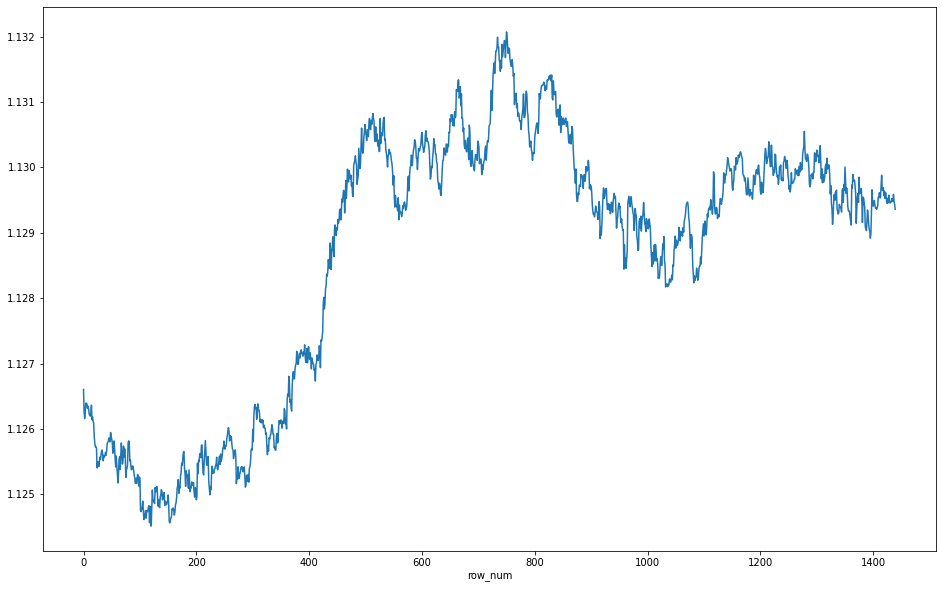

In [33]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120

ax = y_pred.plot(figsize = (16, 10)) 

In [34]:
#contrast leaderboard result of train and test data
predictor.leaderboard(df_train, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetMXNet,-0.00022,-0.00027,0.380411,0.310580,38.129468,0.380411,0.310580,38.129468,1,True,1
1,WeightedEnsemble_L2,-0.00022,-0.00027,0.383982,0.311342,38.132674,0.003572,0.000762,0.003206,2,True,2


In [35]:
# predictor.unpersist_models('agModels-predict_day1')
# predictor.save_space()
# predictor.delete_models(models_to_keep='best', dry_run=False)
%rm -rf agModels-predict_day1
!ls

EURUSD_M5_201001040000_202202112350.csv  sample_data
